# Week 7: Time Series Analysis Project


# Objective of the Project
Compare the average temperature change of 3 EU countries representing the Northern, Central and Southern parts of Europe and and forecast using Time Series Analysis.  Data from Tromso-Norway, Hamburg-Germany and Malaga-Spain are considered representing these areas repectively.   

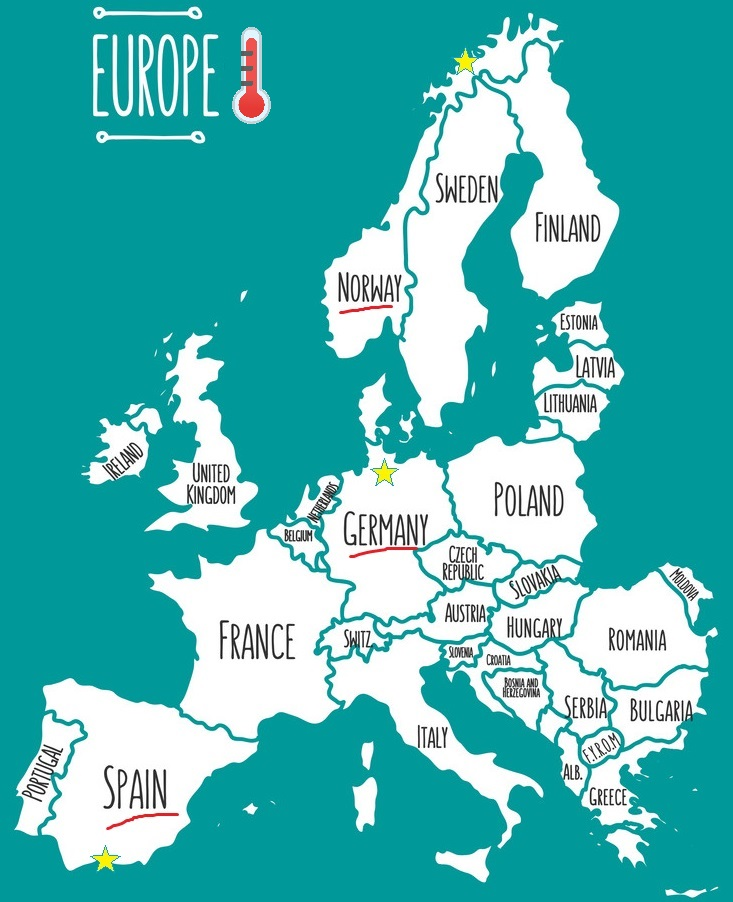

image source: https://www.vectorstock.com/royalty-free-vector/vintage-hand-drawn-europe-travel-map-with-pins-vector-4675081 (edited for personal use only)

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels
import statsmodels.graphics.tsaplots as sgt

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa import stattools
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from datetime import datetime

import warnings
warnings.filterwarnings("ignore")


plt.rcParams.update({'figure.figsize':(20,5)})
sns.set()

## Functions

In [2]:
def cleanValues(df):
    for i in range(1, len(df)):
        j = df.columns.get_loc('TG')
        if df.iat[i, j] == -9999:
            df.iat[i, j] = df.iat[i - 1, j]
    return df

In [3]:
def prepare_data_frame(filename):
    df = pd.read_csv(filename, index_col = 'DATE', parse_dates = ['DATE'], delimiter = ',', header=None, names = ['STAID','SOUID','DATE','TG','Q_TG'],skiprows=21)
    df['YEAR'] = df.index.year
    df = df.loc[(df['YEAR'] >= 1970)]
    df['MONTH'] = df.index.month
    df = cleanValues(df)
    df['TEMP'] = df['TG'] * 0.1
    df = df.drop(columns=['STAID','SOUID','Q_TG','TG'])
    df = df.groupby(['YEAR', 'MONTH'])[['TEMP']].mean().reset_index()
    df['timestep'] =  list(range(len(df)))
    
    df['date'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))
    df = df.set_index('date')

    return df

In [4]:
def plot_dataframe(df, title="Temperature Overtime", ylim=True, ymin=-10):

    df.plot()
    plt.title(title)
    plt.ylabel('Temperature in °C')
    if ylim:
        plt.ylim(ymin)
    plt.show()

In [5]:
def split_data(df):
    size = int(len(df)*0.8)
    df_train = df[:size]
    df_test = df[size:]
    return df_train, df_test

In [6]:
def model_linear_regression(df):
    m = LinearRegression()
    X = df[['timestep']]
    y = df['TEMP']
    m.fit(X, y) 
    return (m, X,y)

In [7]:
def calculate_trend(df,m,X,y):
    df['trend'] = m.predict(X)   
    seasonal_dummies = pd.get_dummies(df['MONTH'],prefix='month',drop_first=True)
    df = df.join(seasonal_dummies)
    X = df.drop(columns=['TEMP', 'YEAR', 'MONTH', 'trend'])
    m.fit(X, y)
    return (df, m, X)

In [8]:
def calculate_seasonal_trend(df,m,X):
    df['trend_seasonal'] = m.predict(X)
    return df

In [9]:
def calculate_remainder(df):
    df['remainder'] = df['TEMP'] - df['trend_seasonal'] #seasonality
    return df

In [10]:
def random_array(df):
    random_array = np.random.normal(loc=0, scale=10, size=df['YEAR'].size)
    df['random'] = random_array
    return df

In [11]:
def get_from_csv(filename):
    df = pd.read_csv(filename, index_col=0, parse_dates=True)
    return df

In [12]:
def add_lag(df):
    df['lag1'] = df['remainder'].shift(1)
    df.dropna(inplace=True)
    return df

In [13]:
def auto_regression(df):
    X = df[['lag1']]
    y = df['remainder']
    m = LinearRegression()
    m.fit(X, y)
    df['predictions_ar1'] = m.predict(X)
    return df

# Data Analysis

In [14]:
norway = prepare_data_frame('tromso_no.txt')
germany = prepare_data_frame('ham_de.txt')
spain = prepare_data_frame('malaga_es.txt')



In [15]:
euro_df = pd.concat([norway['TEMP'],germany['TEMP'],spain['TEMP']], axis=1, keys=['no_temp', 'de_temp', 'sp_temp'])
euro_df

no_temp    de_temp    sp_temp
date                                      
1970-01-01 -3.748387  -2.667742  13.193548
1970-02-01 -8.435714  -0.910714  13.389286
1970-03-01 -2.335484   1.851613  13.870968
1970-04-01 -0.926667   4.763333  16.380000
1970-05-01  4.854839  11.229032  17.883871
...              ...        ...        ...
2020-09-01  8.256667  14.520000  24.213333
2020-10-01  4.206452  11.100000  19.016129
2020-11-01  3.010000   7.663333  16.756667
2020-12-01 -0.225806   4.148387  13.612903
2021-01-01 -3.587097   1.693548  12.416129

[613 rows x 3 columns]

In [16]:
euro_df.describe()

no_temp     de_temp     sp_temp
count  613.000000  613.000000  613.000000
mean     2.967148    9.336634   18.442172
std      5.757592    6.148774    4.957474
min     -8.435714   -5.206452   10.393548
25%     -1.854839    4.496774   14.067857
50%      2.035484    8.923333   17.667742
75%      8.256667   14.836667   23.350000
max     15.122581   22.270968   28.309677

In [17]:
euro_df.isna().sum()

no_temp    0
de_temp    0
sp_temp    0
dtype: int64

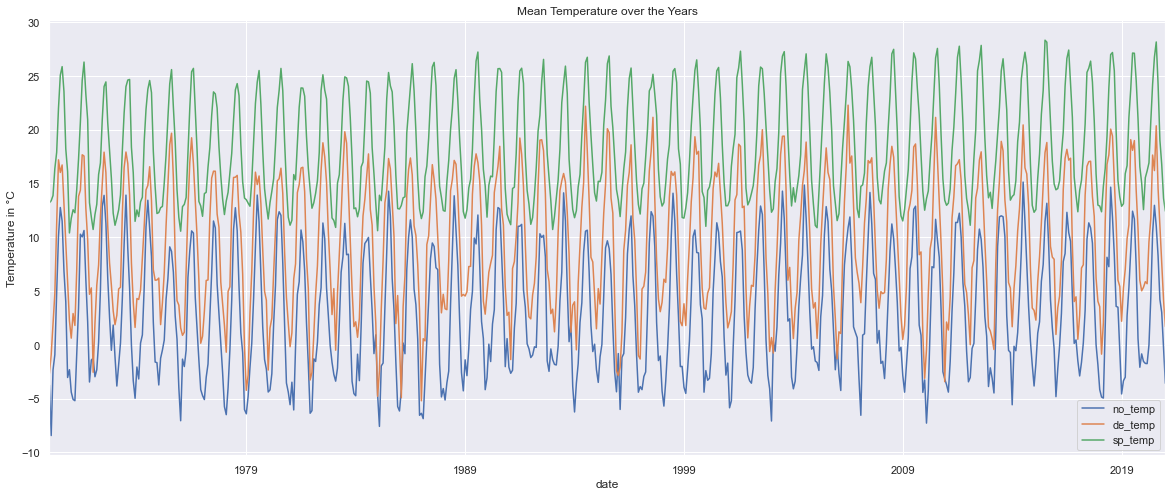

In [18]:
euro_df.plot(figsize=(20,8), title = "Mean Temperature over the Years")
plt.ylabel('Temperature in °C')
plt.show()

# Germany

## Train Test Split

In [19]:
germany.head()

YEAR  MONTH       TEMP  timestep
date                                        
1970-01-01  1970      1  -2.667742         0
1970-02-01  1970      2  -0.910714         1
1970-03-01  1970      3   1.851613         2
1970-04-01  1970      4   4.763333         3
1970-05-01  1970      5  11.229032         4

In [20]:
germany_train, germany_test = split_data(germany)

In [21]:
germany_train.shape, germany_test.shape

((490, 4), (123, 4))

In [22]:
germany_train.tail()

YEAR  MONTH       TEMP  timestep
date                                        
2010-06-01  2010      6  15.700000       485
2010-07-01  2010      7  21.132258       486
2010-08-01  2010      8  17.200000       487
2010-09-01  2010      9  13.266667       488
2010-10-01  2010     10   9.438710       489

In [23]:
germany_test.head()

YEAR  MONTH      TEMP  timestep
date                                       
2010-11-01  2010     11  4.783333       490
2010-12-01  2010     12 -3.432258       491
2011-01-01  2011      1  2.112903       492
2011-02-01  2011      2  1.371429       493
2011-03-01  2011      3  4.419355       494

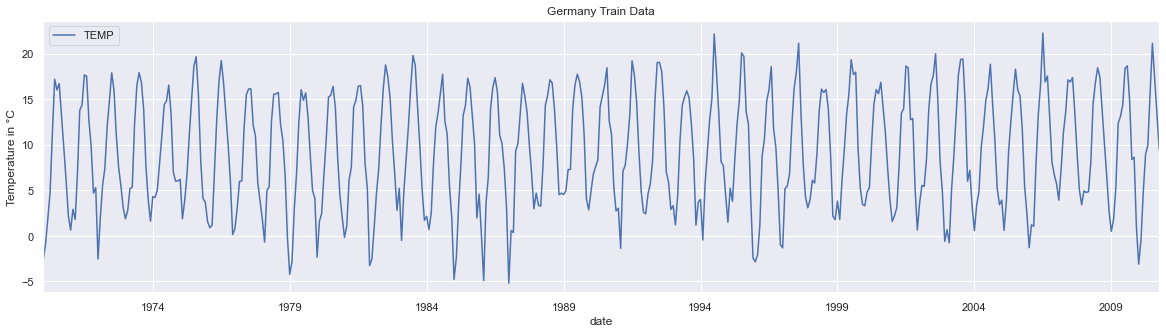

In [24]:
plot_dataframe(germany_train[['TEMP']],title='Germany Train Data',ymin=germany_train['TEMP'].min() - 1)

## Base Model

### Linear Regression

In [25]:
germany_m, germany_X, germany_y= model_linear_regression(germany_train)

#### Trend

In [26]:
germany_train, germany_m, germany_X = calculate_trend(germany_train, germany_m, germany_X, germany_y)

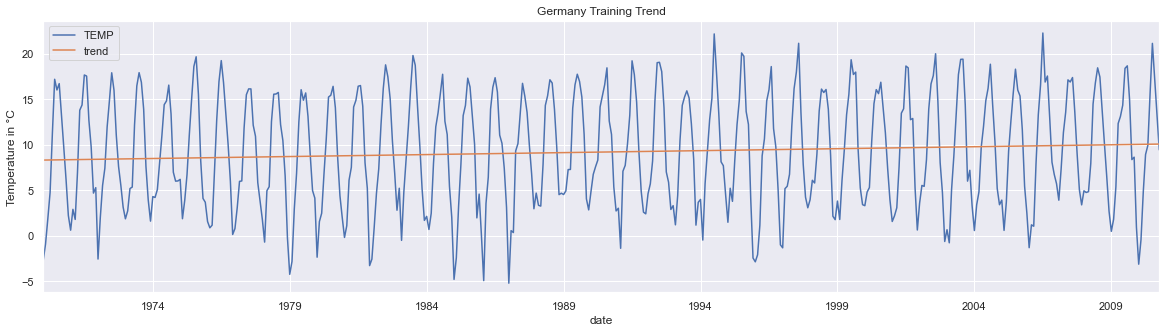

In [27]:
plot_dataframe(germany_train[['TEMP', 'trend']],title='Germany Training Trend',ymin=germany_train['TEMP'].min() - 1)


#### Seasonality

In [28]:
germany_train = calculate_seasonal_trend(germany_train, germany_m, germany_X)

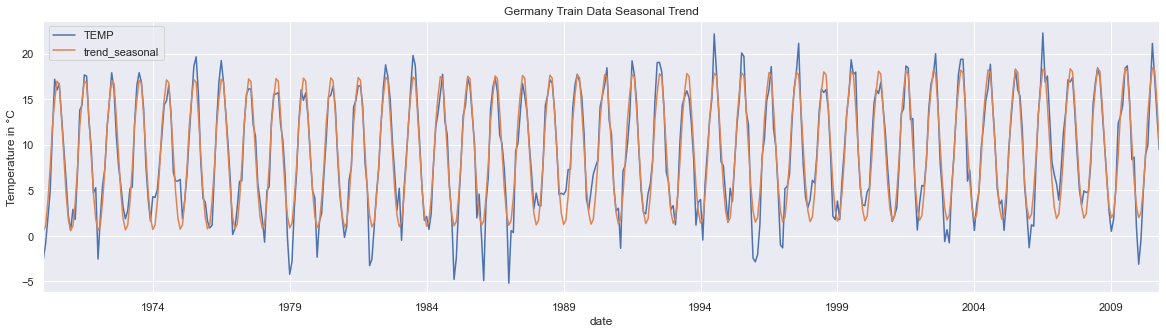

In [29]:
plot_dataframe(germany_train[['TEMP', 'trend_seasonal']],title='Germany Train Data Seasonal Trend',ymin=germany_train['TEMP'].min() - 1)


####  Remainder

In [30]:
germany_train = calculate_remainder(germany_train)

In [31]:
germany_train['remainder'].std()

1.8042807080140812

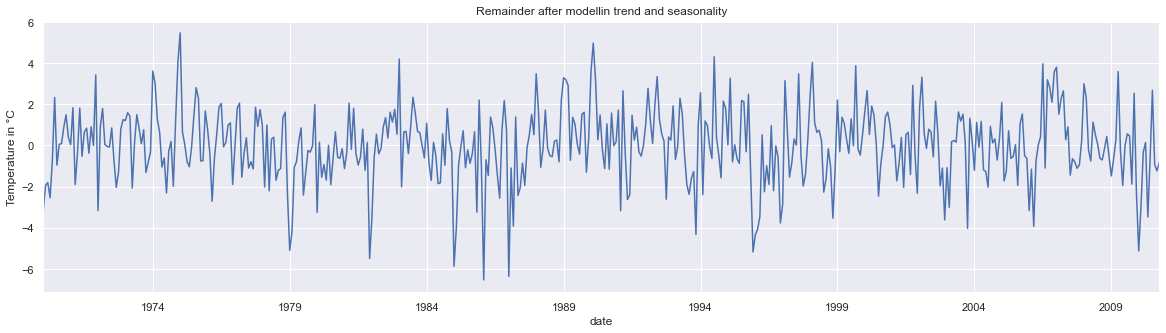

In [32]:
plot_dataframe(germany_train['remainder'], title='Remainder after modellin trend and seasonality', ylim=False)

#### White Noise (Random)

In [33]:
germany_train = random_array(germany_train)

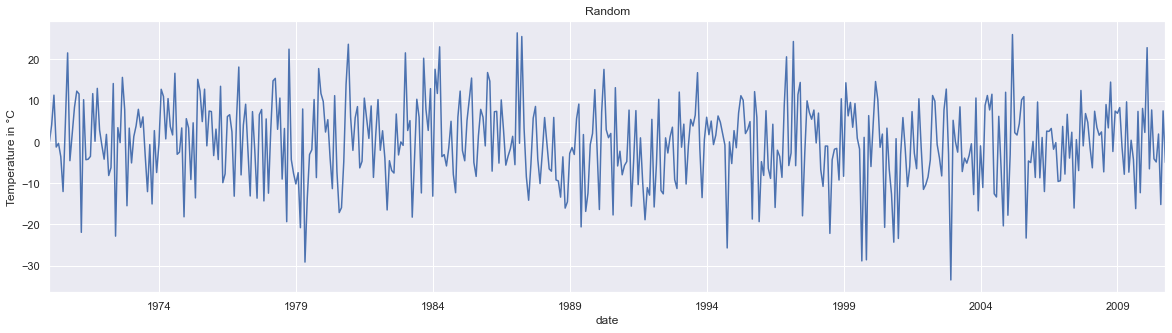

In [34]:
plot_dataframe(germany_train['random'], title='Random', ylim=False)

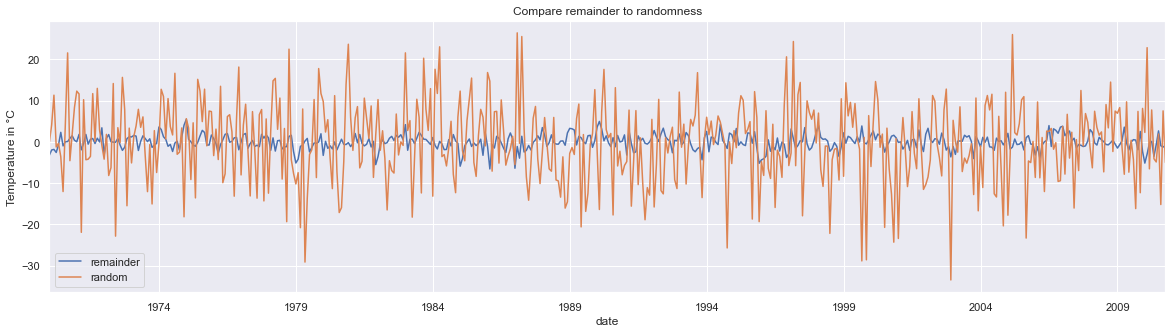

In [35]:
plot_dataframe(germany_train[['remainder', 'random']], title='Compare remainder to randomness', ylim=False)

### Remainder to CSV file

In [36]:
germany_train['remainder'].to_csv('germany_train_remainder.csv')

## AR and Stats Models

In [37]:
df = get_from_csv('germany_train_remainder.csv')
df = add_lag(df)

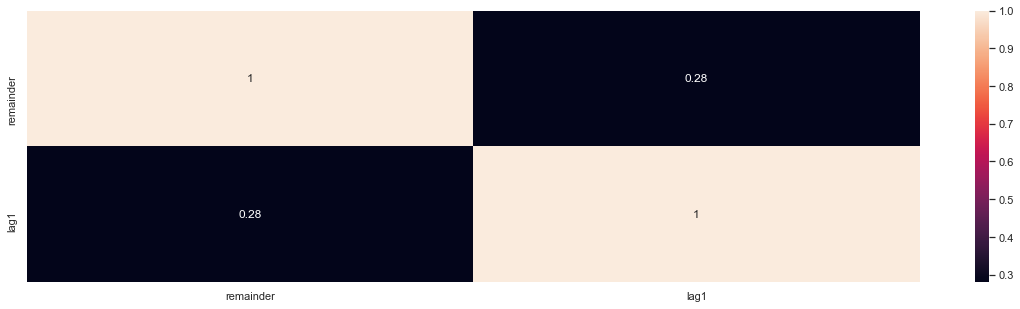

In [38]:
sns.heatmap(round(df.corr(), 2), annot=True)

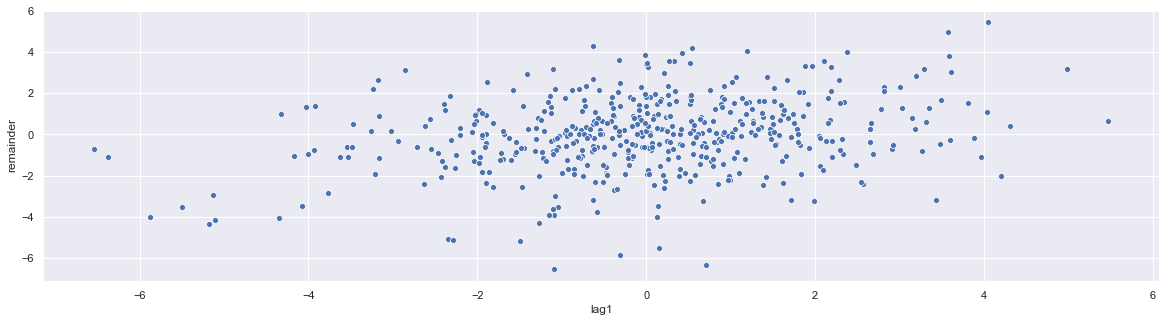

In [39]:
sns.scatterplot(x='lag1', y='remainder', data=df)

### Autoregression Model

In [40]:
df = auto_regression(df)

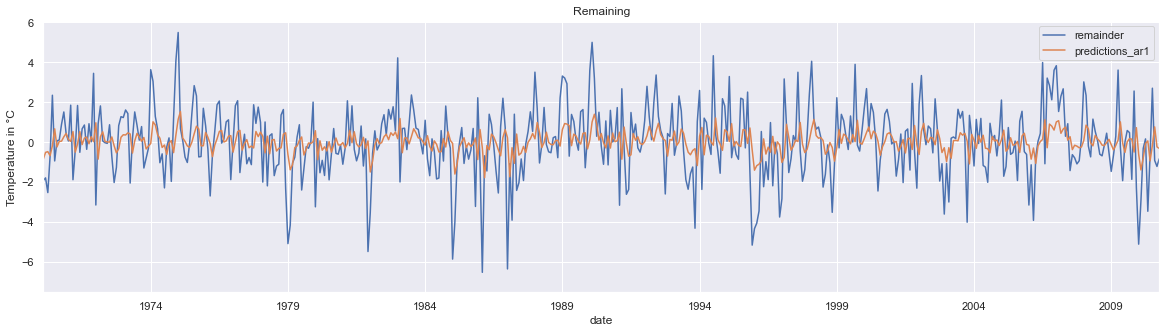

In [41]:
plot_dataframe(df[['remainder', 'predictions_ar1']],title="Remaining",ymin=df['remainder'].min() - 1)

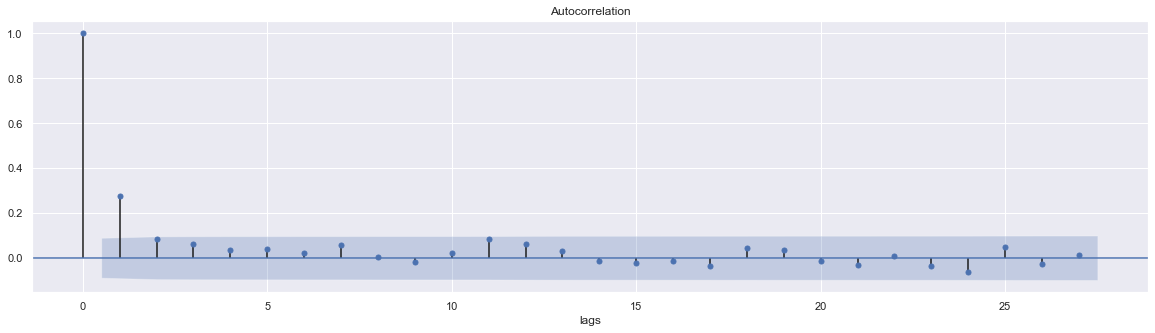

In [42]:
plot_acf(df['remainder'])
plt.xlabel('lags');

In [43]:
df['residual'] = df['remainder'] - df['predictions_ar1']
df.head()

remainder      lag1  predictions_ar1  residual
date                                                      
1970-02-01  -1.941764 -3.206105        -0.879062 -1.062702
1970-03-01  -1.808386 -1.941764        -0.530004 -1.278382
1970-04-01  -2.543831 -1.808386        -0.493181 -2.050650
1970-05-01  -0.706734 -2.543831        -0.696222 -0.010512
1970-06-01   2.333811 -0.706734        -0.189038  2.522850

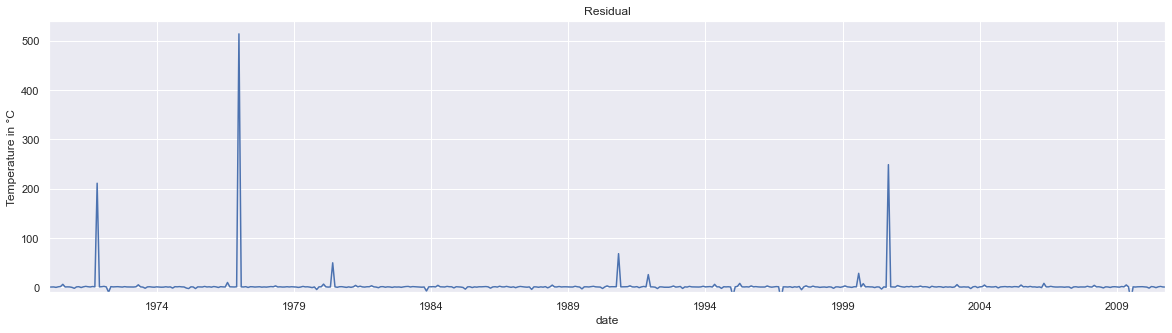

In [44]:
plot_dataframe(df['residual']/df['remainder'],title='Residual')

Add lag2

In [45]:
df['lag2'] = df['remainder'].shift(2)
df.head()

remainder      lag1  predictions_ar1  residual      lag2
date                                                                
1970-02-01  -1.941764 -3.206105        -0.879062 -1.062702       NaN
1970-03-01  -1.808386 -1.941764        -0.530004 -1.278382       NaN
1970-04-01  -2.543831 -1.808386        -0.493181 -2.050650 -1.941764
1970-05-01  -0.706734 -2.543831        -0.696222 -0.010512 -1.808386
1970-06-01   2.333811 -0.706734        -0.189038  2.522850 -2.543831

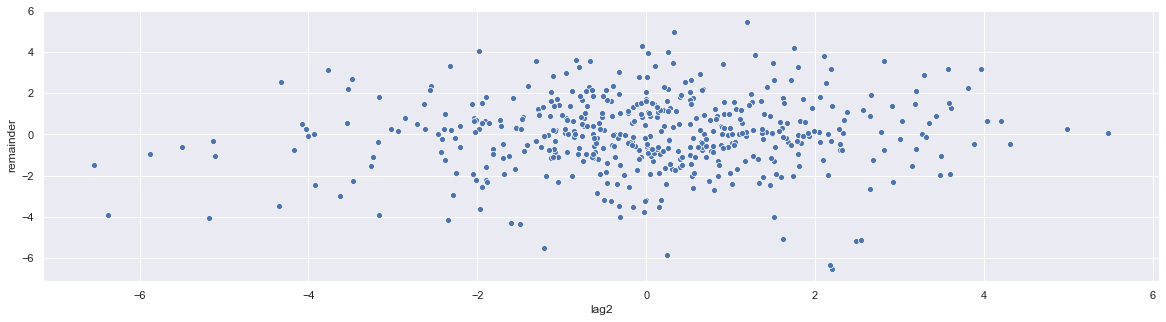

In [46]:
sns.scatterplot(x='lag2', y='remainder', data=df)

In [47]:
round(df[['remainder', 'lag1', 'lag2']].corr(), 2)

remainder  lag1  lag2
remainder       1.00  0.28  0.08
lag1            0.28  1.00  0.27
lag2            0.08  0.27  1.00

### Partial Autocorrelation

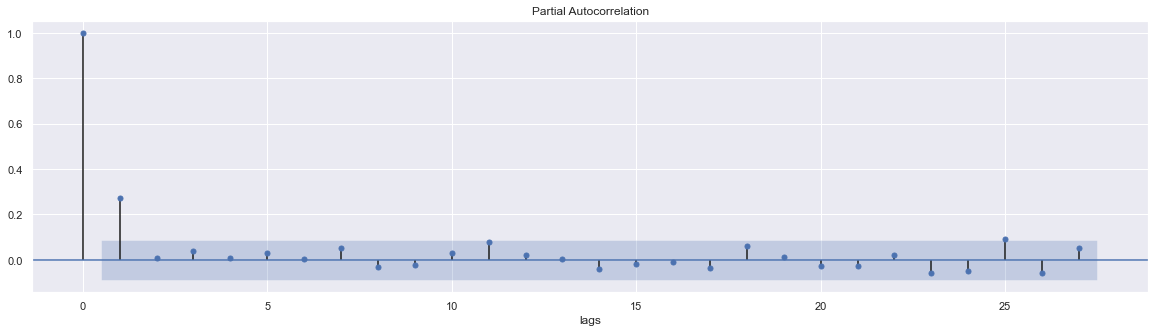

In [48]:
plot_pacf(df['remainder'])
plt.xlabel('lags');

### Statsmodels

In [49]:
selected_order = ar_select_order(df['remainder'], maxlag = 12)

In [50]:
selected_order.ar_lags

array([1])

In [51]:
ar_model = AutoReg(endog=df['remainder'], lags=1).fit()

In [52]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                  489
Model:                     AutoReg(1)   Log Likelihood                -959.700
Method:               Conditional MLE   S.D. of innovations              1.729
Date:                Fri, 12 Mar 2021   AIC                              1.108
Time:                        14:15:09   BIC                              1.133
Sample:                    03-01-1970   HQIC                             1.118
                         - 10-01-2010                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0083      0.078      0.106      0.916      -0.145       0.162
remainder.L1     0.2739      0.043      6.298      0.000       0.189       0.359
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.6507           +0.0000j            3.6507            0.0000
-----------------------------------------------------------------------------
"""

## Run LR on full Model

In [53]:
germany_train = add_lag(germany_train)
germany_train

YEAR  MONTH       TEMP  timestep      trend  month_2  month_3  \
date                                                                        
1970-02-01  1970      2  -0.910714         1   8.319719        1        0   
1970-03-01  1970      3   1.851613         2   8.323311        0        1   
1970-04-01  1970      4   4.763333         3   8.326902        0        0   
1970-05-01  1970      5  11.229032         4   8.330494        0        0   
1970-06-01  1970      6  17.190000         5   8.334086        0        0   
...          ...    ...        ...       ...        ...      ...      ...   
2010-06-01  2010      6  15.700000       485  10.058054        0        0   
2010-07-01  2010      7  21.132258       486  10.061645        0        0   
2010-08-01  2010      8  17.200000       487  10.065237        0        0   
2010-09-01  2010      9  13.266667       488  10.068828        0        0   
2010-10-01  2010     10   9.438710       489  10.072420        0        0   

            month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
date                                                                         
1970-02-01        0        0        0        0        0        0         0   
1970-03-01        0        0        0        0        0        0         0   
1970-04-01        1        0        0        0        0        0         0   
1970-05-01        0        1        0        0        0        0         0   
1970-06-01        0        0        1        0        0        0         0   
...             ...      ...      ...      ...      ...      ...       ...   
2010-06-01        0        0        1        0        0        0         0   
2010-07-01        0        0        0        1        0        0         0   
2010-08-01        0        0        0        0        1        0         0   
2010-09-01        0        0        0        0        0        1         0   
2010-10-01        0        0        0        0        0        0         1   

            month_11  month_12  trend_seasonal  remainder     random      lag1  
date                                                                            
1970-02-01         0         0        1.031050  -1.941764   4.136936 -3.206105  
1970-03-01         0         0        3.659999  -1.808386  11.344595 -1.941764  
1970-04-01         0         0        7.307164  -2.543831  -1.230674 -1.808386  
1970-05-01         0         0       11.935766  -0.706734  -0.335027 -2.543831  
1970-06-01         0         0       14.856189   2.333811  -3.562148 -0.706734  
...              ...       ...             ...        ...        ...       ...  
2010-06-01         0         0       16.327063  -0.627063  -4.849731 -3.480835  
2010-07-01         0         0       18.445666   2.686593   1.925052 -0.627063  
2010-08-01         0         0       18.133864  -0.933864 -15.171049  2.686593  
2010-09-01         0         0       14.500072  -1.233405   7.537565 -0.933864  
2010-10-01         0         0       10.289017  -0.850308  -4.978588 -1.233405  

[489 rows x 20 columns]

In [54]:
# Assign X
X_full = germany_train.drop(columns=['YEAR', 'MONTH', 'TEMP', 'trend', 'trend_seasonal','remainder','random'])
y_full = germany_train['TEMP']

In [55]:
X_full.head()

timestep  month_2  month_3  month_4  month_5  month_6  month_7  \
date                                                                         
1970-02-01         1        1        0        0        0        0        0   
1970-03-01         2        0        1        0        0        0        0   
1970-04-01         3        0        0        1        0        0        0   
1970-05-01         4        0        0        0        1        0        0   
1970-06-01         5        0        0        0        0        1        0   

            month_8  month_9  month_10  month_11  month_12      lag1  
date                                                                  
1970-02-01        0        0         0         0         0 -3.206105  
1970-03-01        0        0         0         0         0 -1.941764  
1970-04-01        0        0         0         0         0 -1.808386  
1970-05-01        0        0         0         0         0 -2.543831  
1970-06-01        0        0         0         0         0 -0.706734

In [56]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [57]:
# Create a new predictions column
germany_train['predictions_full_model'] = m_full.predict(X_full)

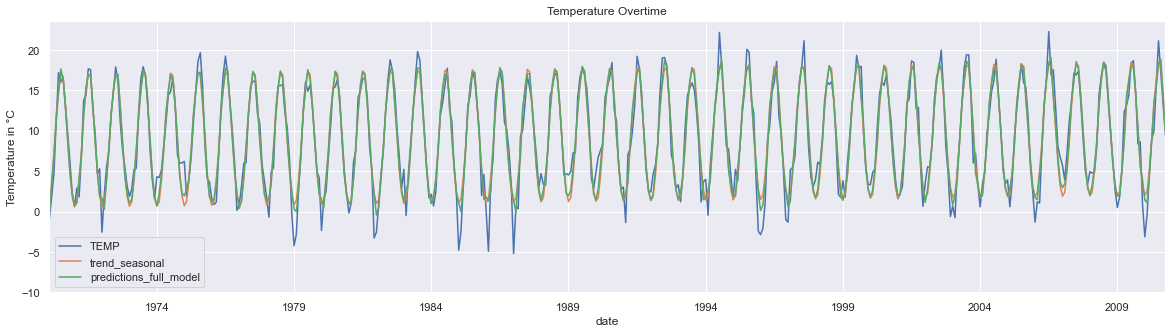

In [58]:
#Plot the prediction vs passengers for the training data

plot_dataframe(germany_train[['TEMP', 'trend_seasonal', 'predictions_full_model']])

In [59]:
pd.DataFrame(m_full.coef_.reshape(1,13), columns=X_full.columns)

timestep   month_2   month_3   month_4   month_5    month_6    month_7  \
0  0.002977  0.409036  3.035008  6.679195  11.30482  14.222265  16.337889   

    month_8    month_9  month_10  month_11  month_12      lag1  
0  16.02311  12.386341  8.172309  3.999247  1.166768  0.276097

## Cross Validate and Optimizing Hyperparameters

In [60]:
X_full

timestep  month_2  month_3  month_4  month_5  month_6  month_7  \
date                                                                         
1970-02-01         1        1        0        0        0        0        0   
1970-03-01         2        0        1        0        0        0        0   
1970-04-01         3        0        0        1        0        0        0   
1970-05-01         4        0        0        0        1        0        0   
1970-06-01         5        0        0        0        0        1        0   
...              ...      ...      ...      ...      ...      ...      ...   
2010-06-01       485        0        0        0        0        1        0   
2010-07-01       486        0        0        0        0        0        1   
2010-08-01       487        0        0        0        0        0        0   
2010-09-01       488        0        0        0        0        0        0   
2010-10-01       489        0        0        0        0        0        0   

            month_8  month_9  month_10  month_11  month_12      lag1  
date                                                                  
1970-02-01        0        0         0         0         0 -3.206105  
1970-03-01        0        0         0         0         0 -1.941764  
1970-04-01        0        0         0         0         0 -1.808386  
1970-05-01        0        0         0         0         0 -2.543831  
1970-06-01        0        0         0         0         0 -0.706734  
...             ...      ...       ...       ...       ...       ...  
2010-06-01        0        0         0         0         0 -3.480835  
2010-07-01        0        0         0         0         0 -0.627063  
2010-08-01        1        0         0         0         0  2.686593  
2010-09-01        0        1         0         0         0 -0.933864  
2010-10-01        0        0         1         0         0 -1.233405  

[489 rows x 13 columns]

In [61]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [62]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print('\n')

The training data for the 1th iteration are the observations steps 
    [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
The validation data for the 1th iteration are the observations steps
    [ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164]


The training data for the 2th iteration are the observations steps 
    [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47

In [63]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full) 

In [64]:
# Do the cross validation
result = cross_val_score(estimator=m_full, X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.911081  , 0.89149749, 0.89880615, 0.92582392, 0.9200284 ])

In [65]:
germany_cv_mean = result.mean()
germany_cv_mean

0.9094473920367332

In [66]:
result_ordinary_cv = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=5)
result_ordinary_cv

array([0.92419695, 0.91389544, 0.89471157, 0.91305435, 0.92083833])

In [67]:
germany_result_ordinary_cv =  result_ordinary_cv.mean()
germany_result_ordinary_cv

0.913339328356706

## Testing

In [68]:
germany_test.head()

YEAR  MONTH      TEMP  timestep
date                                       
2010-11-01  2010     11  4.783333       490
2010-12-01  2010     12 -3.432258       491
2011-01-01  2011      1  2.112903       492
2011-02-01  2011      2  1.371429       493
2011-03-01  2011      3  4.419355       494

In [69]:
# Last timestep of the training data
last_train_timestep = germany_train['timestep'][-1] + 1

In [70]:
# Create a timestep for the model
germany_test['timestep'] = list(range(last_train_timestep + 1, len(germany_test) + last_train_timestep + 1))
germany_test.head()

YEAR  MONTH      TEMP  timestep
date                                       
2010-11-01  2010     11  4.783333       491
2010-12-01  2010     12 -3.432258       492
2011-01-01  2011      1  2.112903       493
2011-02-01  2011      2  1.371429       494
2011-03-01  2011      3  4.419355       495

In [71]:
seasonal_dummies = pd.get_dummies(germany_test.index.month, 
                                  prefix='month', 
                                 drop_first=True).set_index(germany_test.index)

germany_test = germany_test.join(seasonal_dummies)
germany_test.head()

YEAR  MONTH      TEMP  timestep  month_2  month_3  month_4  \
date                                                                     
2010-11-01  2010     11  4.783333       491        0        0        0   
2010-12-01  2010     12 -3.432258       492        0        0        0   
2011-01-01  2011      1  2.112903       493        0        0        0   
2011-02-01  2011      2  1.371429       494        1        0        0   
2011-03-01  2011      3  4.419355       495        0        1        0   

            month_5  month_6  month_7  month_8  month_9  month_10  month_11  \
date                                                                          
2010-11-01        0        0        0        0        0         0         1   
2010-12-01        0        0        0        0        0         0         0   
2011-01-01        0        0        0        0        0         0         0   
2011-02-01        0        0        0        0        0         0         0   
2011-03-01        0        0        0        0        0         0         0   

            month_12  
date                  
2010-11-01         0  
2010-12-01         1  
2011-01-01         0  
2011-02-01         0  
2011-03-01         0

In [72]:
# Assign X_test
X_test = germany_test.drop(columns=['TEMP'])

In [73]:
# Predict trend and seasonality
germany_m, germany_X, germany_y= model_linear_regression(germany_test)
germany_test = calculate_seasonal_trend(germany_test, germany_m, germany_X)
germany_test.head()

YEAR  MONTH      TEMP  timestep  month_2  month_3  month_4  \
date                                                                     
2010-11-01  2010     11  4.783333       491        0        0        0   
2010-12-01  2010     12 -3.432258       492        0        0        0   
2011-01-01  2011      1  2.112903       493        0        0        0   
2011-02-01  2011      2  1.371429       494        1        0        0   
2011-03-01  2011      3  4.419355       495        0        1        0   

            month_5  month_6  month_7  month_8  month_9  month_10  month_11  \
date                                                                          
2010-11-01        0        0        0        0        0         0         1   
2010-12-01        0        0        0        0        0         0         0   
2011-01-01        0        0        0        0        0         0         0   
2011-02-01        0        0        0        0        0         0         0   
2011-03-01        0        0        0        0        0         0         0   

            month_12  trend_seasonal  
date                                  
2010-11-01         0        8.782306  
2010-12-01         1        8.800691  
2011-01-01         0        8.819075  
2011-02-01         0        8.837460  
2011-03-01         0        8.855844

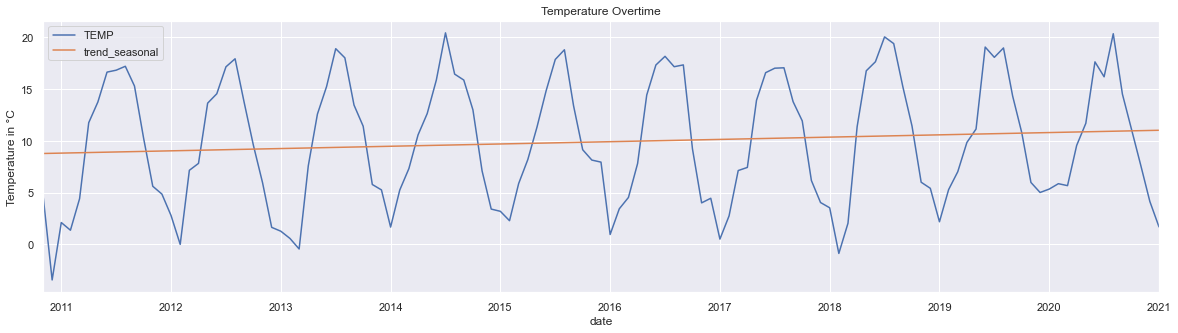

In [74]:
plot_dataframe(germany_test[['TEMP', 'trend_seasonal']], ylim=False)

In [75]:
# Calculate the remainder for the test set
germany_test['remainder'] = germany_test['TEMP'] - germany_test['trend_seasonal']

# Create the lagged variable
germany_test['lag1'] = germany_test['remainder'].shift(1)

In [76]:
# Assign X_full
X_full = germany_test.drop(columns=['YEAR','MONTH','TEMP', 'trend_seasonal', 'remainder'])

In [77]:
X_full.head() # Contains a NaN for the first value of lag1

timestep  month_2  month_3  month_4  month_5  month_6  month_7  \
date                                                                         
2010-11-01       491        0        0        0        0        0        0   
2010-12-01       492        0        0        0        0        0        0   
2011-01-01       493        0        0        0        0        0        0   
2011-02-01       494        1        0        0        0        0        0   
2011-03-01       495        0        1        0        0        0        0   

            month_8  month_9  month_10  month_11  month_12       lag1  
date                                                                   
2010-11-01        0        0         0         1         0        NaN  
2010-12-01        0        0         0         0         1  -3.998973  
2011-01-01        0        0         0         0         0 -12.232949  
2011-02-01        0        0         0         0         0  -6.706172  
2011-03-01        0        0         0         0         0  -7.466031

In [78]:
X_full.loc['2010-11-01', 'lag1'] = germany_train.loc['2010-10-01', 'remainder']

In [79]:
# Create the predictions
germany_test['predictions_full_model'] = m_full.predict(X_full)

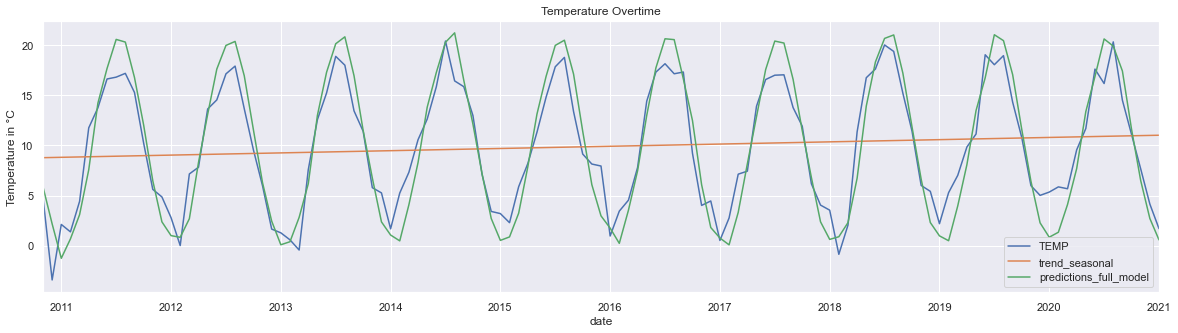

In [80]:
plot_dataframe(germany_test[['TEMP', 'trend_seasonal', 'predictions_full_model']], ylim=False)

In [81]:
# Create the complete dataset and plot it
germany_full = germany_train[['TEMP', 'trend_seasonal', 'predictions_full_model']].append(germany_test[['TEMP', 'trend_seasonal', 'predictions_full_model']])

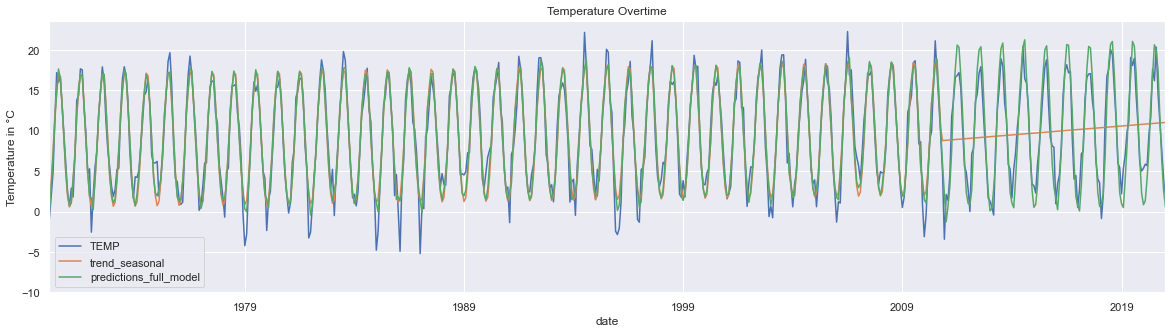

In [82]:
plot_dataframe(germany_full)

In [83]:
germany_test_lr_score = m_full.score(X_full, germany_test['TEMP'])
germany_test_lr_score 

0.8444614873458081

## Predict the future


In [84]:
germany_test.head()

YEAR  MONTH      TEMP  timestep  month_2  month_3  month_4  \
date                                                                     
2010-11-01  2010     11  4.783333       491        0        0        0   
2010-12-01  2010     12 -3.432258       492        0        0        0   
2011-01-01  2011      1  2.112903       493        0        0        0   
2011-02-01  2011      2  1.371429       494        1        0        0   
2011-03-01  2011      3  4.419355       495        0        1        0   

            month_5  month_6  month_7  month_8  month_9  month_10  month_11  \
date                                                                          
2010-11-01        0        0        0        0        0         0         1   
2010-12-01        0        0        0        0        0         0         0   
2011-01-01        0        0        0        0        0         0         0   
2011-02-01        0        0        0        0        0         0         0   
2011-03-01        0        0        0        0        0         0         0   

            month_12  trend_seasonal  remainder       lag1  \
date                                                         
2010-11-01         0        8.782306  -3.998973        NaN   
2010-12-01         1        8.800691 -12.232949  -3.998973   
2011-01-01         0        8.819075  -6.706172 -12.232949   
2011-02-01         0        8.837460  -7.466031  -6.706172   
2011-03-01         0        8.855844  -4.436490  -7.466031   

            predictions_full_model  
date                                
2010-11-01                5.866289  
2010-12-01                2.167451  
2011-01-01               -1.269715  
2011-02-01                0.668224  
2011-03-01                3.087379

In [85]:
germany_combined = germany_train.append(germany_test)
germany_combined.tail()

YEAR  MONTH       TEMP  timestep  trend  month_2  month_3  \
date                                                                    
2020-09-01  2020      9  14.520000       609    NaN        0        0   
2020-10-01  2020     10  11.100000       610    NaN        0        0   
2020-11-01  2020     11   7.663333       611    NaN        0        0   
2020-12-01  2020     12   4.148387       612    NaN        0        0   
2021-01-01  2021      1   1.693548       613    NaN        0        0   

            month_4  month_5  month_6  ...  month_8  month_9  month_10  \
date                                   ...                               
2020-09-01        0        0        0  ...        0        1         0   
2020-10-01        0        0        0  ...        0        0         1   
2020-11-01        0        0        0  ...        0        0         0   
2020-12-01        0        0        0  ...        0        0         0   
2021-01-01        0        0        0  ...        0        0         0   

            month_11  month_12  trend_seasonal  remainder  random      lag1  \
date                                                                          
2020-09-01         0         0       10.951677   3.568323     NaN  9.418321   
2020-10-01         0         0       10.970061   0.129939     NaN  3.568323   
2020-11-01         1         0       10.988446  -3.325112     NaN  0.129939   
2020-12-01         0         1       11.006830  -6.858443     NaN -3.325112   
2021-01-01         0         0       11.025215  -9.331666     NaN -6.858443   

            predictions_full_model  
date                                
2020-09-01               17.439856  
2020-10-01               11.613636  
2020-11-01                6.494224  
2020-12-01                2.710793  
2021-01-01                0.571461  

[5 rows x 21 columns]

In [86]:
# Re-train the model on the whole dataset
X_combined = germany_combined.drop(columns=['YEAR','MONTH','TEMP', 'trend_seasonal', 'remainder', 'predictions_full_model','trend','random'])
y_combined = germany_combined['TEMP']

In [87]:
X_combined.loc['2010-11-01', 'lag1'] = germany_train.loc['2010-10-01', 'remainder']


In [88]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [89]:
X_combined.head(1)

timestep  month_2  month_3  month_4  month_5  month_6  month_7  \
date                                                                         
1970-02-01         1        1        0        0        0        0        0   

            month_8  month_9  month_10  month_11  month_12      lag1  
date                                                                  
1970-02-01        0        0         0         0         0 -3.206105

In [90]:
[0] * 11

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [91]:
# What is the first date in the future? --> 2021-02-01
timestep = germany_combined['timestep'].max() + 1
months = [0] * 11
lag = germany_combined.loc['2021-01-01', 'remainder']

In [92]:
timestep, months, lag

(614, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], -9.33166622109161)

In [93]:
X_future = []

X_future.append(timestep)

X_future.extend(months)

X_future.append(lag)

X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

timestep  month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
0       614        0        0        0        0        0        0        0   

   month_9  month_10  month_11  month_12      lag1  
0        0         0         0         0 -9.331666

In [94]:
# Prediction for 2021-02-01

germany_f1 = m_combined.predict(X_future)
germany_f1 = germany_f1.round(4)

In [95]:
# How does this look like for 2021-03-01?
timestep = germany_combined['timestep'].max() + 1
months = [1] + [0]*10
lag = 0 


In [96]:
X_future_2 = pd.DataFrame([[timestep] + months + [lag]])
X_future_2.columns = X_combined.columns
X_future_2

timestep  month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
0       614        1        0        0        0        0        0        0   

   month_9  month_10  month_11  month_12  lag1  
0        0         0         0         0     0

In [97]:
# Prediction for 2021-03-01

germany_f2 = m_combined.predict(X_future_2)
germany_f2 = germany_f2.round(4)

# Norway

## Train Test Split

In [98]:
norway.head()

YEAR  MONTH      TEMP  timestep
date                                       
1970-01-01  1970      1 -3.748387         0
1970-02-01  1970      2 -8.435714         1
1970-03-01  1970      3 -2.335484         2
1970-04-01  1970      4 -0.926667         3
1970-05-01  1970      5  4.854839         4

In [99]:
norway_train, norway_test = split_data(norway)

In [100]:
norway_train.shape, norway_test.shape

((490, 4), (123, 4))

In [101]:
norway_train.tail()

YEAR  MONTH       TEMP  timestep
date                                        
2010-06-01  2010      6   7.160000       485
2010-07-01  2010      7  11.661290       486
2010-08-01  2010      8   9.735484       487
2010-09-01  2010      9   8.133333       488
2010-10-01  2010     10   3.277419       489

In [102]:
norway_test.head()

YEAR  MONTH      TEMP  timestep
date                                       
2010-11-01  2010     11 -2.510000       490
2010-12-01  2010     12 -3.170968       491
2011-01-01  2011      1 -3.709677       492
2011-02-01  2011      2 -4.400000       493
2011-03-01  2011      3 -1.541935       494

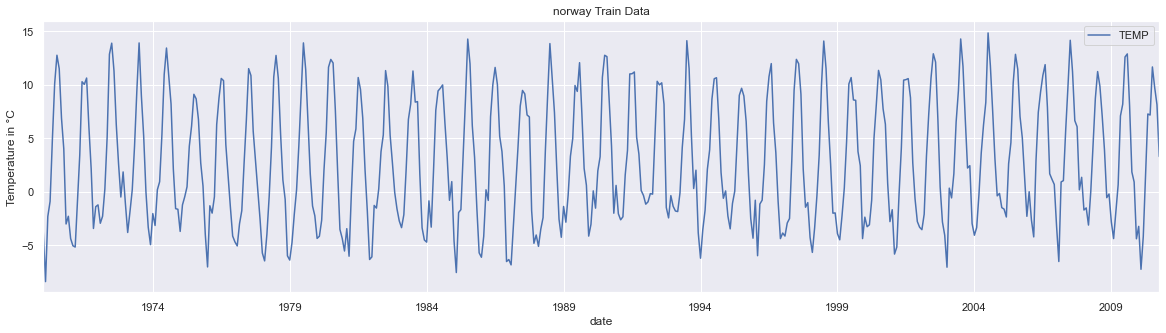

In [103]:
plot_dataframe(norway_train[['TEMP']],title='norway Train Data',ymin=norway_train['TEMP'].min() - 1)

## Base Model

### Linear Regression

In [104]:
norway_m, norway_X, norway_y= model_linear_regression(norway_train)

#### Trend

In [105]:
norway_train, norway_m, norway_X = calculate_trend(norway_train, norway_m, norway_X, norway_y)

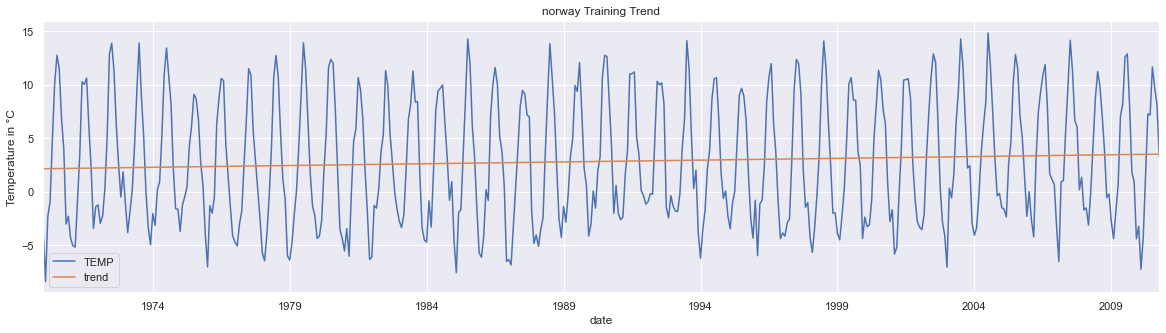

In [106]:
plot_dataframe(norway_train[['TEMP', 'trend']],title='norway Training Trend',ymin=norway_train['TEMP'].min() - 1)


#### Seasonality

In [107]:
norway_train = calculate_seasonal_trend(norway_train, norway_m, norway_X)

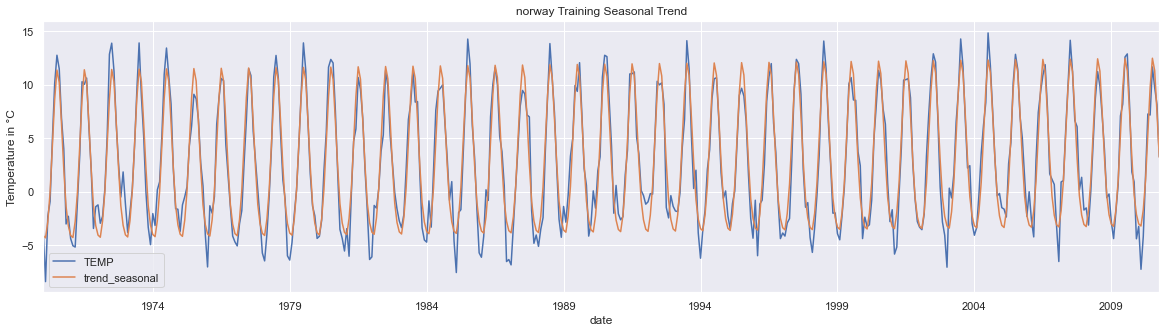

In [108]:
plot_dataframe(norway_train[['TEMP', 'trend_seasonal']],title='norway Training Seasonal Trend',ymin=norway_train['TEMP'].min() - 1)


####  Remainder

In [109]:
norway_train = calculate_remainder(norway_train)

In [110]:
norway_train['remainder'].std()

1.606115602692634

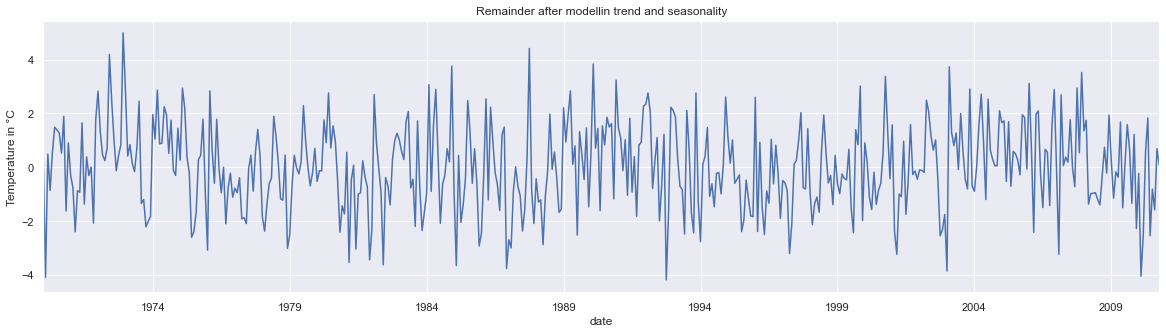

In [111]:
plot_dataframe(norway_train['remainder'], title='Remainder after modellin trend and seasonality', ylim=False)

#### White Noise (Random)

In [112]:
norway_train = random_array(norway_train)

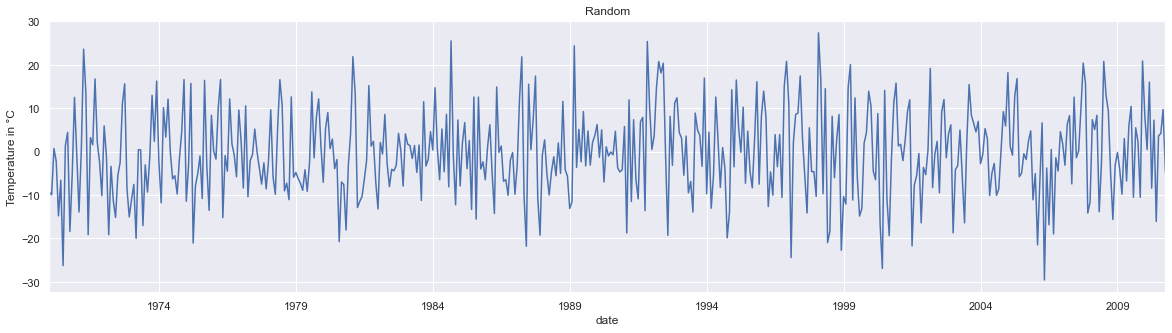

In [113]:
plot_dataframe(norway_train['random'], title='Random', ylim=False)

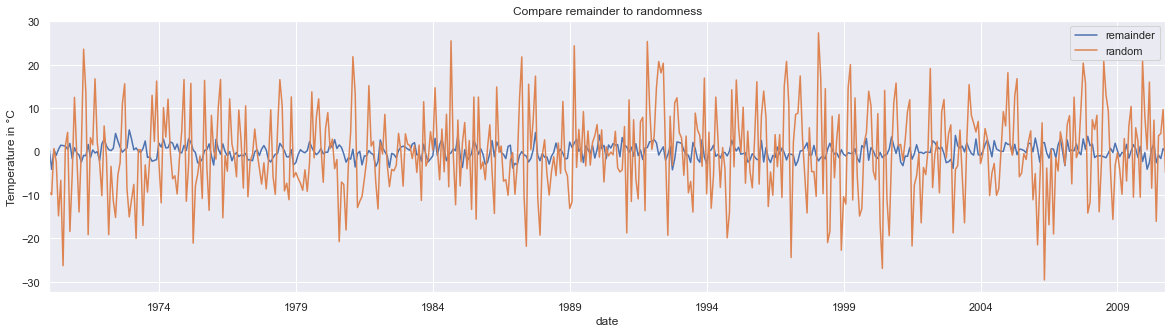

In [114]:
plot_dataframe(norway_train[['remainder', 'random']], title='Compare remainder to randomness', ylim=False)

### Remainder to CSV file

In [115]:
norway_train['remainder'].to_csv('norway_train_remainder.csv')

## AR and Stats Models

In [116]:
df = get_from_csv('norway_train_remainder.csv')
df = add_lag(df)

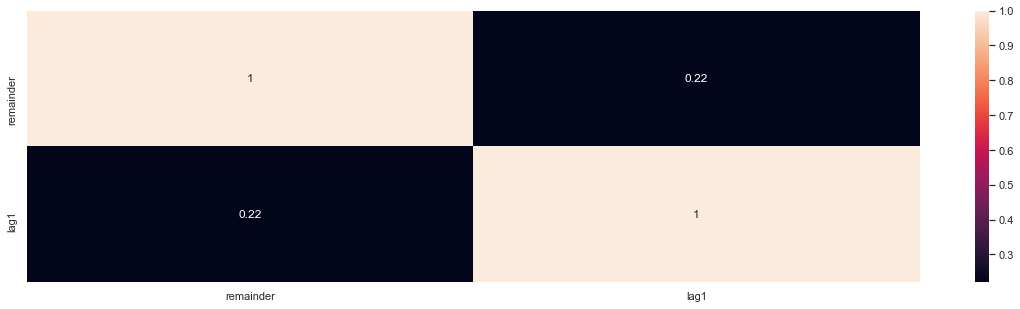

In [117]:
sns.heatmap(round(df.corr(), 2), annot=True)

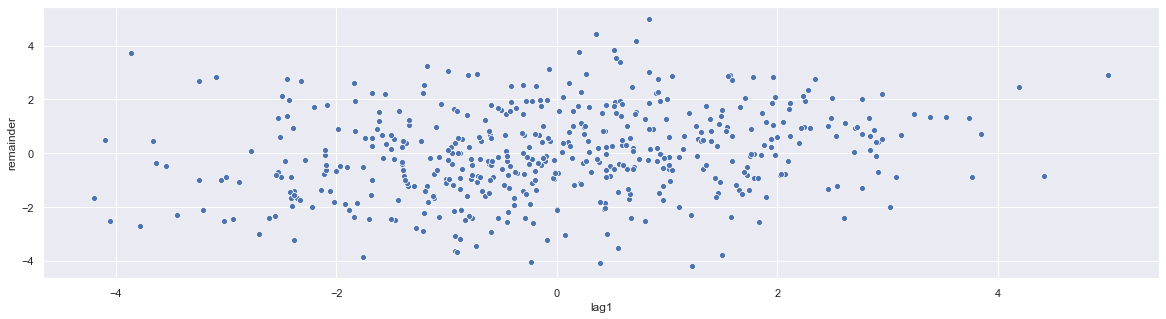

In [118]:
sns.scatterplot(x='lag1', y='remainder', data=df)

### Autoregression Model

In [119]:
df = auto_regression(df)

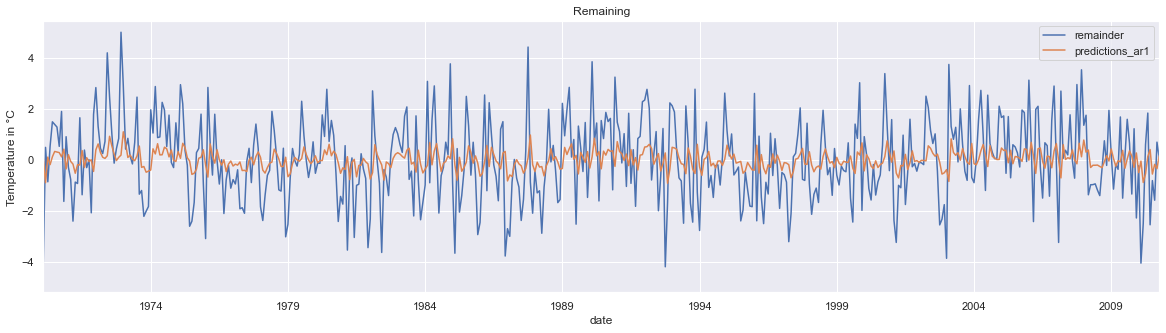

In [120]:
plot_dataframe(df[['remainder', 'predictions_ar1']],title="Remaining",ymin=df['remainder'].min() - 1)

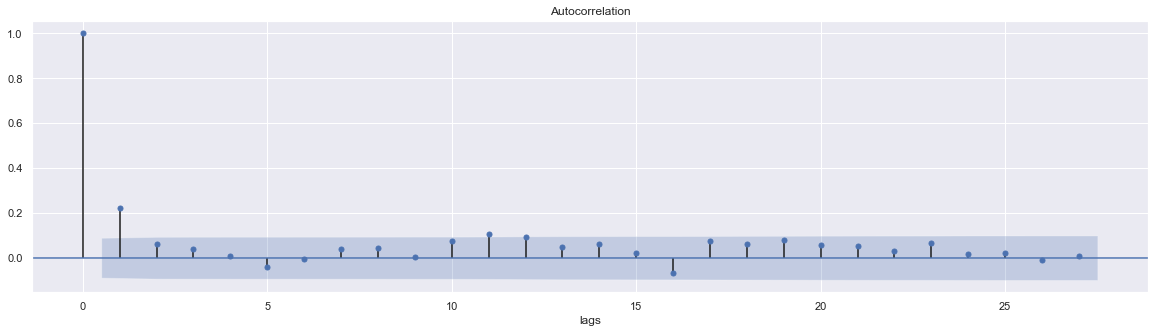

In [121]:
plot_acf(df['remainder'])
plt.xlabel('lags');

In [122]:
df['residual'] = df['remainder'] - df['predictions_ar1']
df.head()

remainder      lag1  predictions_ar1  residual
date                                                      
1970-02-01  -4.099146  0.388912         0.084629 -4.183775
1970-03-01   0.485686 -4.099146        -0.900779  1.386465
1970-04-01  -0.863986  0.485686         0.105877 -0.969864
1970-05-01   0.535646 -0.863986        -0.190460  0.726106
1970-06-01   1.488046  0.535646         0.116847  1.371199

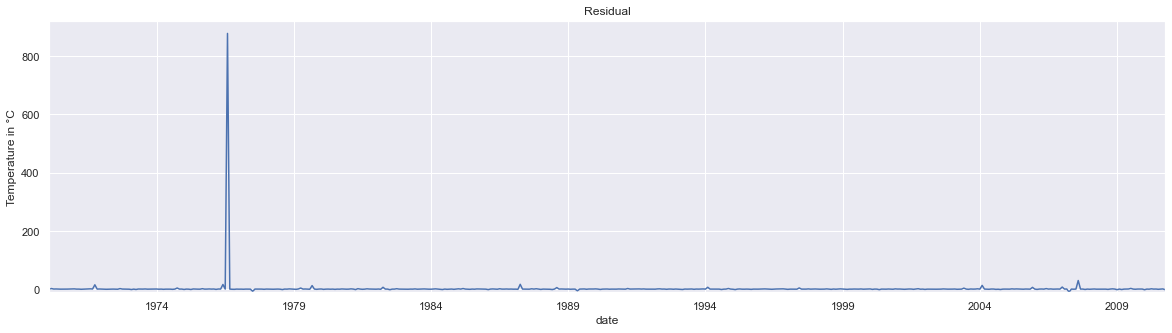

In [123]:
plot_dataframe(df['residual']/df['remainder'],title='Residual')

Add lag2

In [124]:
df['lag2'] = df['remainder'].shift(2)
df.head()

remainder      lag1  predictions_ar1  residual      lag2
date                                                                
1970-02-01  -4.099146  0.388912         0.084629 -4.183775       NaN
1970-03-01   0.485686 -4.099146        -0.900779  1.386465       NaN
1970-04-01  -0.863986  0.485686         0.105877 -0.969864 -4.099146
1970-05-01   0.535646 -0.863986        -0.190460  0.726106  0.485686
1970-06-01   1.488046  0.535646         0.116847  1.371199 -0.863986

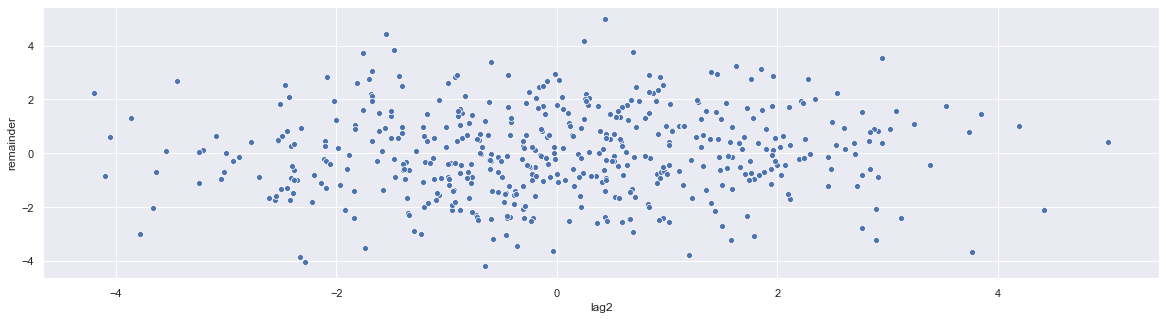

In [125]:
sns.scatterplot(x='lag2', y='remainder', data=df)

In [126]:
round(df[['remainder', 'lag1', 'lag2']].corr(), 2)

remainder  lag1  lag2
remainder       1.00  0.22  0.06
lag1            0.22  1.00  0.22
lag2            0.06  0.22  1.00

### Partial Autocorrelation

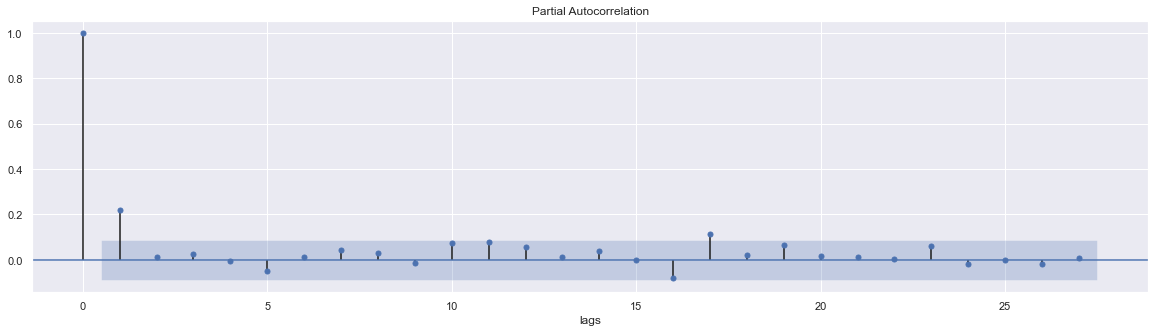

In [127]:
plot_pacf(df['remainder'])
plt.xlabel('lags');

### Statsmodels

In [128]:
selected_order = ar_select_order(df['remainder'], maxlag = 12)

In [129]:
selected_order.ar_lags

array([1])

In [130]:
ar_model = AutoReg(endog=df['remainder'], lags=1).fit()

In [131]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                  489
Model:                     AutoReg(1)   Log Likelihood                -908.487
Method:               Conditional MLE   S.D. of innovations              1.557
Date:                Fri, 12 Mar 2021   AIC                              0.898
Time:                        14:15:30   BIC                              0.923
Sample:                    03-01-1970   HQIC                             0.908
                         - 10-01-2010                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0078      0.070      0.111      0.912      -0.130       0.146
remainder.L1     0.2209      0.044      5.038      0.000       0.135       0.307
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            4.5278           +0.0000j            4.5278            0.0000
-----------------------------------------------------------------------------
"""

## Run LR on full Model

In [132]:
norway_train = add_lag(norway_train)
norway_train

YEAR  MONTH       TEMP  timestep     trend  month_2  month_3  \
date                                                                       
1970-02-01  1970      2  -8.435714         1  2.135387        1        0   
1970-03-01  1970      3  -2.335484         2  2.138181        0        1   
1970-04-01  1970      4  -0.926667         3  2.140975        0        0   
1970-05-01  1970      5   4.854839         4  2.143769        0        0   
1970-06-01  1970      6  10.090000         5  2.146563        0        0   
...          ...    ...        ...       ...       ...      ...      ...   
2010-06-01  2010      6   7.160000       485  3.487593        0        0   
2010-07-01  2010      7  11.661290       486  3.490387        0        0   
2010-08-01  2010      8   9.735484       487  3.493181        0        0   
2010-09-01  2010      9   8.133333       488  3.495975        0        0   
2010-10-01  2010     10   3.277419       489  3.498768        0        0   

            month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
date                                                                         
1970-02-01        0        0        0        0        0        0         0   
1970-03-01        0        0        0        0        0        0         0   
1970-04-01        1        0        0        0        0        0         0   
1970-05-01        0        1        0        0        0        0         0   
1970-06-01        0        0        1        0        0        0         0   
...             ...      ...      ...      ...      ...      ...       ...   
2010-06-01        0        0        1        0        0        0         0   
2010-07-01        0        0        0        1        0        0         0   
2010-08-01        0        0        0        0        1        0         0   
2010-09-01        0        0        0        0        0        1         0   
2010-10-01        0        0        0        0        0        0         1   

            month_11  month_12  trend_seasonal  remainder     random      lag1  
date                                                                            
1970-02-01         0         0       -4.336568  -4.099146  -9.946043  0.388912  
1970-03-01         0         0       -2.821170   0.485686   0.718287 -4.099146  
1970-04-01         0         0       -0.062680  -0.863986  -2.249267  0.485686  
1970-05-01         0         0        4.319192   0.535646 -14.794933 -0.863986  
1970-06-01         0         0        8.601954   1.488046  -6.593000  0.535646  
...              ...       ...             ...        ...        ...       ...  
2010-06-01         0         0        9.709753  -2.549753 -16.079269  1.831073  
2010-07-01         0         0       12.477897  -0.816606   3.652192 -2.549753  
2010-08-01         0         0       11.322035  -1.586551   4.161581 -0.816606  
2010-09-01         0         0        7.442436   0.690897   9.717411 -1.586551  
2010-10-01         0         0        3.201264   0.076155  -4.798459  0.690897  

[489 rows x 20 columns]

In [133]:
# Assign X
X_full = norway_train.drop(columns=['YEAR', 'MONTH', 'TEMP', 'trend', 'trend_seasonal','remainder','random'])
y_full = norway_train['TEMP']

In [134]:
X_full.head()

timestep  month_2  month_3  month_4  month_5  month_6  month_7  \
date                                                                         
1970-02-01         1        1        0        0        0        0        0   
1970-03-01         2        0        1        0        0        0        0   
1970-04-01         3        0        0        1        0        0        0   
1970-05-01         4        0        0        0        1        0        0   
1970-06-01         5        0        0        0        0        1        0   

            month_8  month_9  month_10  month_11  month_12      lag1  
date                                                                  
1970-02-01        0        0         0         0         0  0.388912  
1970-03-01        0        0         0         0         0 -4.099146  
1970-04-01        0        0         0         0         0  0.485686  
1970-05-01        0        0         0         0         0 -0.863986  
1970-06-01        0        0         0         0         0  0.535646

In [135]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [136]:
# Create a new predictions column
norway_train['predictions_full_model'] = m_full.predict(X_full)

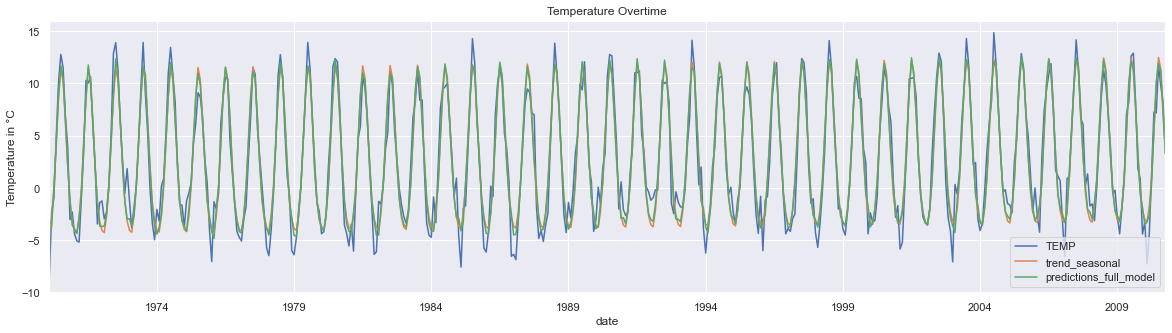

In [137]:
#Plot the prediction vs passengers for the training data

plot_dataframe(norway_train[['TEMP', 'trend_seasonal', 'predictions_full_model']])

In [138]:
pd.DataFrame(m_full.coef_.reshape(1,13), columns=X_full.columns)

timestep   month_2   month_3   month_4   month_5    month_6    month_7  \
0  0.002318 -0.191804  1.321277  4.077448  8.457003  12.737446  15.503271   

     month_8    month_9  month_10  month_11  month_12      lag1  
0  14.345091  10.463174  6.219684  2.716995  0.898286  0.219563

## Cross Validate and Optimizing Hyperparameters

In [139]:
X_full

timestep  month_2  month_3  month_4  month_5  month_6  month_7  \
date                                                                         
1970-02-01         1        1        0        0        0        0        0   
1970-03-01         2        0        1        0        0        0        0   
1970-04-01         3        0        0        1        0        0        0   
1970-05-01         4        0        0        0        1        0        0   
1970-06-01         5        0        0        0        0        1        0   
...              ...      ...      ...      ...      ...      ...      ...   
2010-06-01       485        0        0        0        0        1        0   
2010-07-01       486        0        0        0        0        0        1   
2010-08-01       487        0        0        0        0        0        0   
2010-09-01       488        0        0        0        0        0        0   
2010-10-01       489        0        0        0        0        0        0   

            month_8  month_9  month_10  month_11  month_12      lag1  
date                                                                  
1970-02-01        0        0         0         0         0  0.388912  
1970-03-01        0        0         0         0         0 -4.099146  
1970-04-01        0        0         0         0         0  0.485686  
1970-05-01        0        0         0         0         0 -0.863986  
1970-06-01        0        0         0         0         0  0.535646  
...             ...      ...       ...       ...       ...       ...  
2010-06-01        0        0         0         0         0  1.831073  
2010-07-01        0        0         0         0         0 -2.549753  
2010-08-01        1        0         0         0         0 -0.816606  
2010-09-01        0        1         0         0         0 -1.586551  
2010-10-01        0        0         1         0         0  0.690897  

[489 rows x 13 columns]

In [140]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [141]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print('\n')

The training data for the 1th iteration are the observations steps 
    [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
The validation data for the 1th iteration are the observations steps
    [ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164]


The training data for the 2th iteration are the observations steps 
    [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47

In [142]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full) 

In [143]:
# Do the cross validation
result = cross_val_score(estimator=m_full, X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.93436435, 0.90601092, 0.90119037, 0.93596321, 0.91104463])

In [144]:
norway_cv_mean = result.mean()
norway_cv_mean

0.9177146967390744

In [145]:
result_ordinary_cv = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=5)
result_ordinary_cv

array([0.92235978, 0.92522815, 0.90629527, 0.93905978, 0.90744244])

In [146]:
norway_result_ordinary_cv = result_ordinary_cv.mean()
norway_result_ordinary_cv

0.9200770861737144

## Testing

In [147]:
norway_test.head()

YEAR  MONTH      TEMP  timestep
date                                       
2010-11-01  2010     11 -2.510000       490
2010-12-01  2010     12 -3.170968       491
2011-01-01  2011      1 -3.709677       492
2011-02-01  2011      2 -4.400000       493
2011-03-01  2011      3 -1.541935       494

In [148]:
# Last timestep of the training data
last_train_timestep = norway_train['timestep'][-1] + 1

In [149]:
# Create a timestep for the model
norway_test['timestep'] = list(range(last_train_timestep + 1, len(norway_test) + last_train_timestep + 1))
norway_test.head()

YEAR  MONTH      TEMP  timestep
date                                       
2010-11-01  2010     11 -2.510000       491
2010-12-01  2010     12 -3.170968       492
2011-01-01  2011      1 -3.709677       493
2011-02-01  2011      2 -4.400000       494
2011-03-01  2011      3 -1.541935       495

In [150]:
seasonal_dummies = pd.get_dummies(norway_test.index.month, 
                                  prefix='month', 
                                 drop_first=True).set_index(norway_test.index)

norway_test = norway_test.join(seasonal_dummies)
norway_test.head()

YEAR  MONTH      TEMP  timestep  month_2  month_3  month_4  \
date                                                                     
2010-11-01  2010     11 -2.510000       491        0        0        0   
2010-12-01  2010     12 -3.170968       492        0        0        0   
2011-01-01  2011      1 -3.709677       493        0        0        0   
2011-02-01  2011      2 -4.400000       494        1        0        0   
2011-03-01  2011      3 -1.541935       495        0        1        0   

            month_5  month_6  month_7  month_8  month_9  month_10  month_11  \
date                                                                          
2010-11-01        0        0        0        0        0         0         1   
2010-12-01        0        0        0        0        0         0         0   
2011-01-01        0        0        0        0        0         0         0   
2011-02-01        0        0        0        0        0         0         0   
2011-03-01        0        0        0        0        0         0         0   

            month_12  
date                  
2010-11-01         0  
2010-12-01         1  
2011-01-01         0  
2011-02-01         0  
2011-03-01         0

In [151]:
# Assign X_test
X_test = norway_test.drop(columns=['TEMP'])

In [152]:
# Predict trend and seasonality
norway_m, norway_X, norway_y= model_linear_regression(norway_test)
norway_test = calculate_seasonal_trend(norway_test, norway_m, norway_X)
norway_test.head()

YEAR  MONTH      TEMP  timestep  month_2  month_3  month_4  \
date                                                                     
2010-11-01  2010     11 -2.510000       491        0        0        0   
2010-12-01  2010     12 -3.170968       492        0        0        0   
2011-01-01  2011      1 -3.709677       493        0        0        0   
2011-02-01  2011      2 -4.400000       494        1        0        0   
2011-03-01  2011      3 -1.541935       495        0        1        0   

            month_5  month_6  month_7  month_8  month_9  month_10  month_11  \
date                                                                          
2010-11-01        0        0        0        0        0         0         1   
2010-12-01        0        0        0        0        0         0         0   
2011-01-01        0        0        0        0        0         0         0   
2011-02-01        0        0        0        0        0         0         0   
2011-03-01        0        0        0        0        0         0         0   

            month_12  trend_seasonal  
date                                  
2010-11-01         0        3.278872  
2010-12-01         1        3.283653  
2011-01-01         0        3.288435  
2011-02-01         0        3.293217  
2011-03-01         0        3.297998

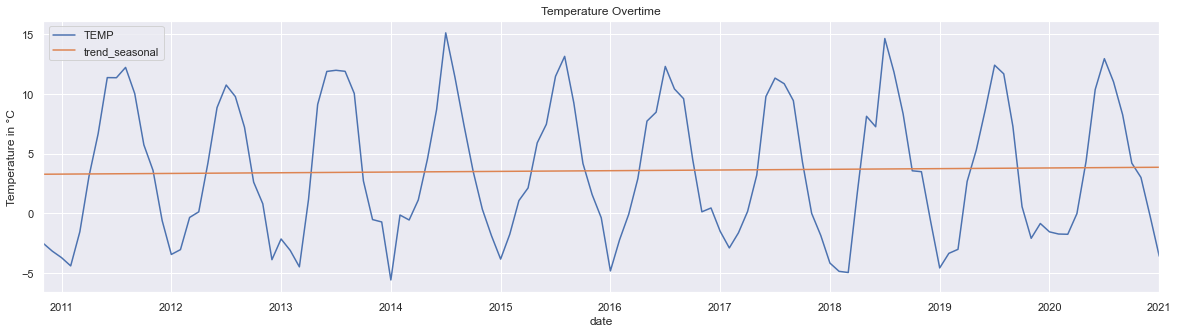

In [153]:
plot_dataframe(norway_test[['TEMP', 'trend_seasonal']], ylim=False)

In [154]:
# Calculate the remainder for the test set
norway_test['remainder'] = norway_test['TEMP'] - norway_test['trend_seasonal']

# Create the lagged variable
norway_test['lag1'] = norway_test['remainder'].shift(1)

In [155]:
# Assign X_full
X_full = norway_test.drop(columns=['YEAR','MONTH','TEMP', 'trend_seasonal', 'remainder'])

In [156]:
X_full.head() # Contains a NaN for the first value of lag1

timestep  month_2  month_3  month_4  month_5  month_6  month_7  \
date                                                                         
2010-11-01       491        0        0        0        0        0        0   
2010-12-01       492        0        0        0        0        0        0   
2011-01-01       493        0        0        0        0        0        0   
2011-02-01       494        1        0        0        0        0        0   
2011-03-01       495        0        1        0        0        0        0   

            month_8  month_9  month_10  month_11  month_12      lag1  
date                                                                  
2010-11-01        0        0         0         1         0       NaN  
2010-12-01        0        0         0         0         1 -5.788872  
2011-01-01        0        0         0         0         0 -6.454621  
2011-02-01        0        0         0         0         0 -6.998112  
2011-03-01        0        0         0         0         0 -7.693217

In [157]:
X_full.loc['2010-11-01', 'lag1'] = norway_train.loc['2010-10-01', 'remainder']

In [158]:
# Create the predictions
norway_test['predictions_full_model'] = m_full.predict(X_full)

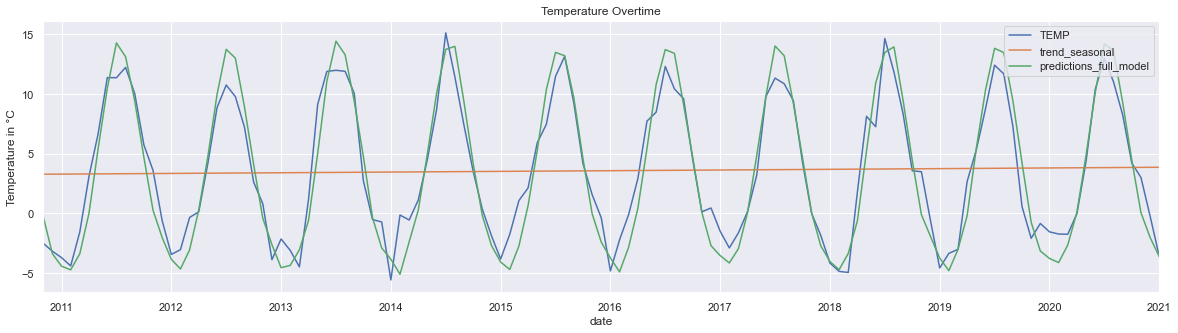

In [159]:
plot_dataframe(norway_test[['TEMP', 'trend_seasonal', 'predictions_full_model']], ylim=False)

In [160]:
# Create the complete dataset and plot it
norway_full = norway_train[['TEMP', 'trend_seasonal', 'predictions_full_model']].append(norway_test[['TEMP', 'trend_seasonal', 'predictions_full_model']])

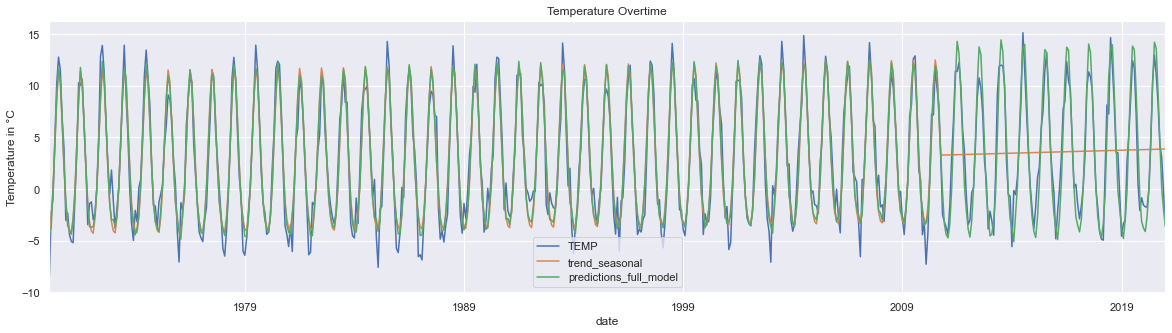

In [161]:
plot_dataframe(norway_full)

In [162]:
norway_test_lr_score = m_full.score(X_full, norway_test['TEMP'])
norway_test_lr_score

0.8901606332267192

## Predict the future


In [163]:
norway_test.head()

YEAR  MONTH      TEMP  timestep  month_2  month_3  month_4  \
date                                                                     
2010-11-01  2010     11 -2.510000       491        0        0        0   
2010-12-01  2010     12 -3.170968       492        0        0        0   
2011-01-01  2011      1 -3.709677       493        0        0        0   
2011-02-01  2011      2 -4.400000       494        1        0        0   
2011-03-01  2011      3 -1.541935       495        0        1        0   

            month_5  month_6  month_7  month_8  month_9  month_10  month_11  \
date                                                                          
2010-11-01        0        0        0        0        0         0         1   
2010-12-01        0        0        0        0        0         0         0   
2011-01-01        0        0        0        0        0         0         0   
2011-02-01        0        0        0        0        0         0         0   
2011-03-01        0        0        0        0        0         0         0   

            month_12  trend_seasonal  remainder      lag1  \
date                                                        
2010-11-01         0        3.278872  -5.788872       NaN   
2010-12-01         1        3.283653  -6.454621 -5.788872   
2011-01-01         0        3.288435  -6.998112 -6.454621   
2011-02-01         0        3.293217  -7.693217 -6.998112   
2011-03-01         0        3.297998  -4.839934 -7.693217   

            predictions_full_model  
date                                
2010-11-01               -0.277609  
2010-12-01               -3.381741  
2011-01-01               -4.423882  
2011-02-01               -4.732698  
2011-03-01               -3.369918

In [164]:
norway_combined = norway_train.append(norway_test)
norway_combined.tail()

YEAR  MONTH      TEMP  timestep  trend  month_2  month_3  month_4  \
date                                                                            
2020-09-01  2020      9  8.256667       609    NaN        0        0        0   
2020-10-01  2020     10  4.206452       610    NaN        0        0        0   
2020-11-01  2020     11  3.010000       611    NaN        0        0        0   
2020-12-01  2020     12 -0.225806       612    NaN        0        0        0   
2021-01-01  2021      1 -3.587097       613    NaN        0        0        0   

            month_5  month_6  ...  month_8  month_9  month_10  month_11  \
date                          ...                                         
2020-09-01        0        0  ...        0        1         0         0   
2020-10-01        0        0  ...        0        0         1         0   
2020-11-01        0        0  ...        0        0         0         1   
2020-12-01        0        0  ...        0        0         0         0   
2021-01-01        0        0  ...        0        0         0         0   

            month_12  trend_seasonal  remainder  random      lag1  \
date                                                                
2020-09-01         0        3.843104   4.413563     NaN  7.184258   
2020-10-01         0        3.847886   0.358566     NaN  4.413563   
2020-11-01         0        3.852667  -0.842667     NaN  0.358566   
2020-12-01         1        3.857449  -4.083255     NaN -0.842667   
2021-01-01         0        3.862231  -7.449327     NaN -4.083255   

            predictions_full_model  
date                                
2020-09-01                9.302786  
2020-10-01                4.453273  
2020-11-01                0.062577  
2020-12-01               -2.017560  
2021-01-01               -3.625040  

[5 rows x 21 columns]

In [165]:
# Re-train the model on the whole dataset
X_combined = norway_combined.drop(columns=['YEAR','MONTH','TEMP', 'trend_seasonal', 'remainder', 'predictions_full_model','trend','random'])
y_combined = norway_combined['TEMP']

In [166]:
X_combined.loc['2010-11-01', 'lag1'] = norway_train.loc['2010-10-01', 'remainder']


In [167]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [168]:
X_combined.head(1)

timestep  month_2  month_3  month_4  month_5  month_6  month_7  \
date                                                                         
1970-02-01         1        1        0        0        0        0        0   

            month_8  month_9  month_10  month_11  month_12      lag1  
date                                                                  
1970-02-01        0        0         0         0         0  0.388912

In [169]:
[0] * 11

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [170]:
# What is the first date in the future? --> 2021-02-01
timestep = norway_combined['timestep'].max() + 1
months = [0] * 11
lag = norway_combined.loc['2021-01-01', 'remainder']

In [171]:
timestep, months, lag

(614, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], -7.449327290293658)

In [172]:
X_future = []

X_future.append(timestep)
X_future.extend(months)
X_future.append(lag)
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

timestep  month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
0       614        0        0        0        0        0        0        0   

   month_9  month_10  month_11  month_12      lag1  
0        0         0         0         0 -7.449327

In [173]:
# Prediction for 2021-02-01

norway_f1= m_combined.predict(X_future)
norway_f1 = norway_f1.round(4)

In [174]:
# How does this look like for 2021-03-01?
timestep = norway_combined['timestep'].max() + 1
months = [1] + [0]*10
lag = 0 


In [175]:
X_future_2 = pd.DataFrame([[timestep] + months + [lag]])
X_future_2.columns = X_combined.columns
X_future_2

timestep  month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
0       614        1        0        0        0        0        0        0   

   month_9  month_10  month_11  month_12  lag1  
0        0         0         0         0     0

In [176]:
# Prediction for 2021-03-01

norway_f2 = m_combined.predict(X_future_2)
norway_f2 = norway_f2.round(4)

# Spain

## Train Test Split

In [177]:
spain.head()

YEAR  MONTH       TEMP  timestep
date                                        
1970-01-01  1970      1  13.193548         0
1970-02-01  1970      2  13.389286         1
1970-03-01  1970      3  13.870968         2
1970-04-01  1970      4  16.380000         3
1970-05-01  1970      5  17.883871         4

In [178]:
spain_train, spain_test = split_data(spain)

In [179]:
spain_train.shape, spain_test.shape

((490, 4), (123, 4))

In [180]:
spain_train.tail()

YEAR  MONTH       TEMP  timestep
date                                        
2010-06-01  2010      6  23.143333       485
2010-07-01  2010      7  26.664516       486
2010-08-01  2010      8  27.545161       487
2010-09-01  2010      9  24.183333       488
2010-10-01  2010     10  19.483871       489

In [181]:
spain_test.head()

YEAR  MONTH       TEMP  timestep
date                                        
2010-11-01  2010     11  15.406667       490
2010-12-01  2010     12  13.429032       491
2011-01-01  2011      1  12.964516       492
2011-02-01  2011      2  13.164286       493
2011-03-01  2011      3  14.470968       494

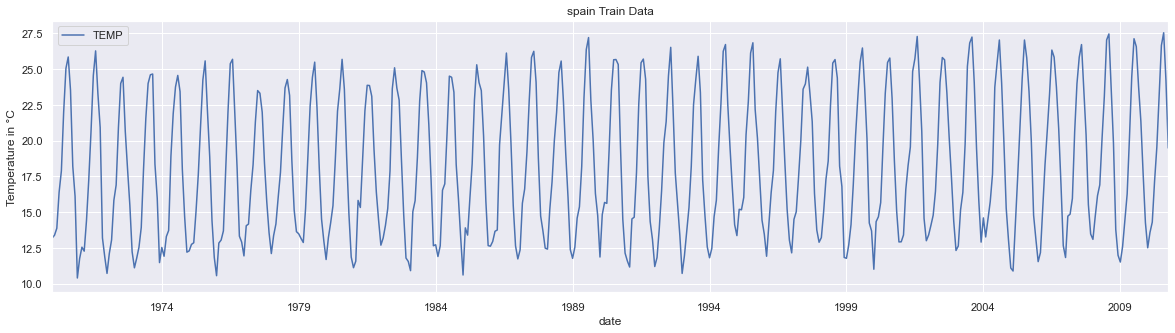

In [182]:
plot_dataframe(spain_train[['TEMP']],title='spain Train Data',ymin=spain_train['TEMP'].min() - 1)

## Base Model

### Linear Regression

In [183]:
spain_m, spain_X, spain_y= model_linear_regression(spain_train)

#### Trend

In [184]:
spain_train, spain_m, spain_X = calculate_trend(spain_train, spain_m, spain_X, spain_y)

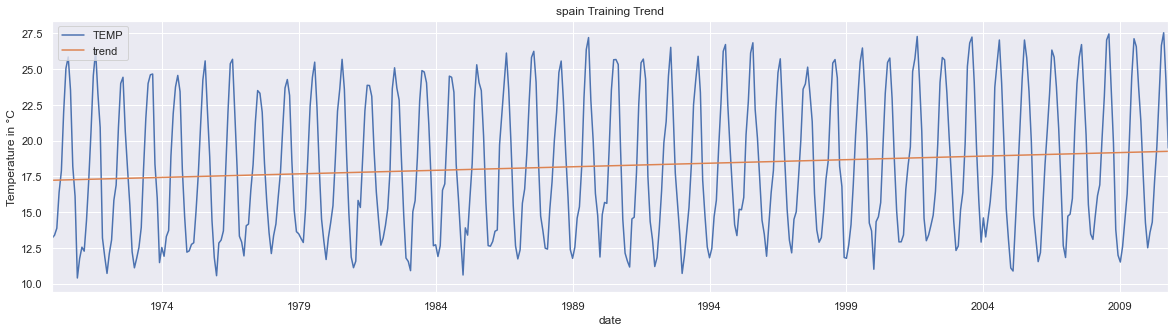

In [185]:
plot_dataframe(spain_train[['TEMP', 'trend']],title='spain Training Trend',ymin=spain_train['TEMP'].min() - 1)


#### Seasonality

In [186]:
spain_train = calculate_seasonal_trend(spain_train, spain_m, spain_X)

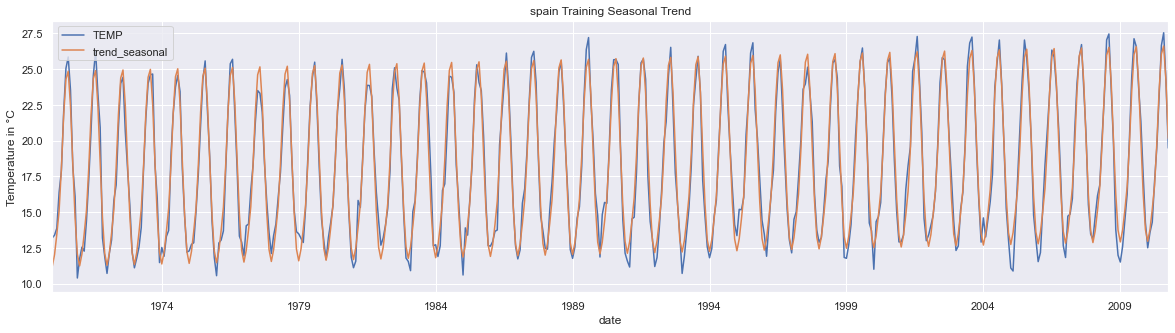

In [187]:
plot_dataframe(spain_train[['TEMP', 'trend_seasonal']],title='spain Training Seasonal Trend',ymin=spain_train['TEMP'].min() - 1)


####  Remainder

In [188]:
spain_train = calculate_remainder(spain_train)

In [189]:
spain_train['remainder'].std()

0.8954963656130059

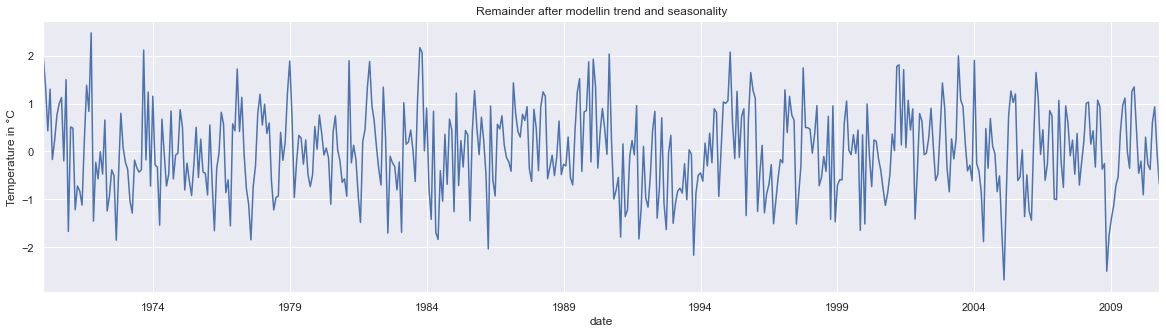

In [190]:
plot_dataframe(spain_train['remainder'], title='Remainder after modellin trend and seasonality', ylim=False)

#### White Noise (Random)

In [191]:
spain_train = random_array(spain_train)

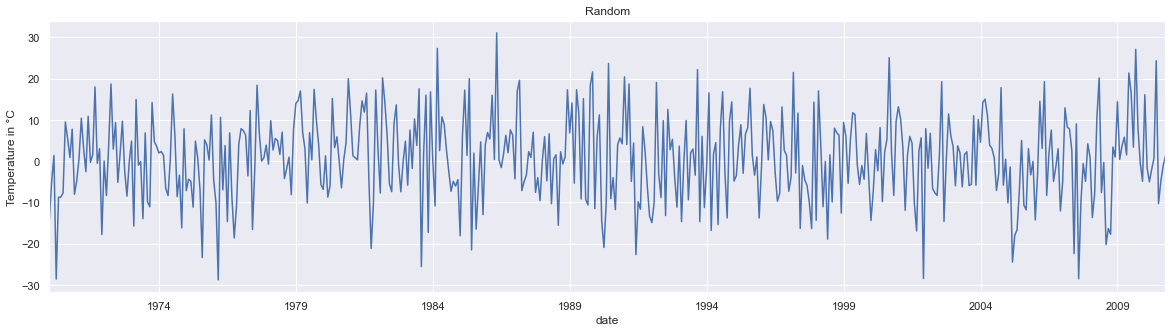

In [192]:
plot_dataframe(spain_train['random'], title='Random', ylim=False)

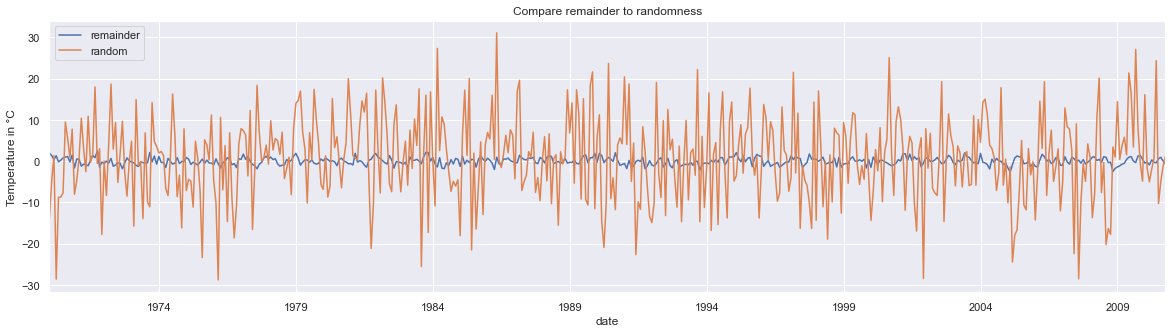

In [193]:
plot_dataframe(spain_train[['remainder', 'random']], title='Compare remainder to randomness', ylim=False)

### Remainder to CSV file

In [194]:
spain_train['remainder'].to_csv('spain_train_remainder.csv')

## AR and Stats Models

In [195]:
df = get_from_csv('spain_train_remainder.csv')
df = add_lag(df)

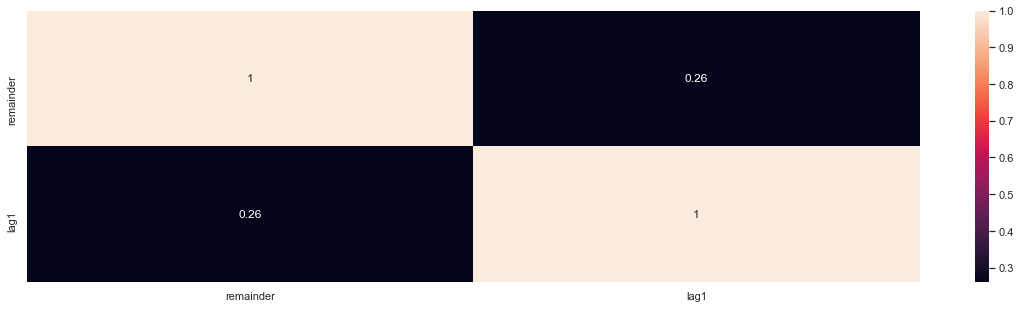

In [196]:
sns.heatmap(round(df.corr(), 2), annot=True)

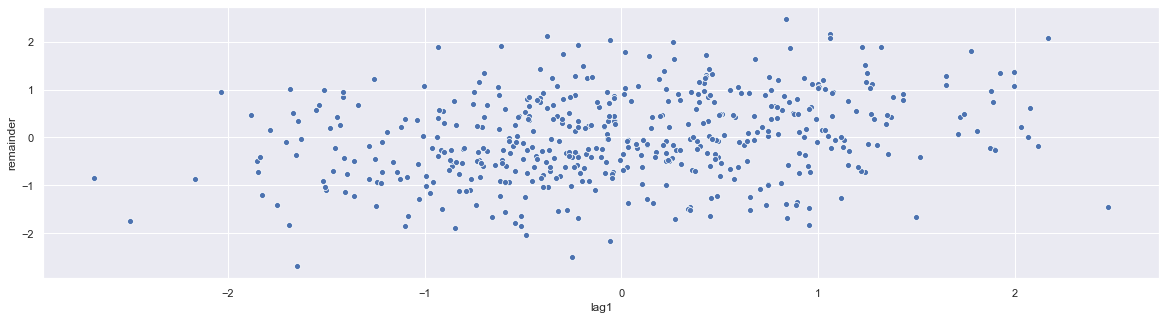

In [197]:
sns.scatterplot(x='lag1', y='remainder', data=df)

### Autoregression Model

In [198]:
df = auto_regression(df)

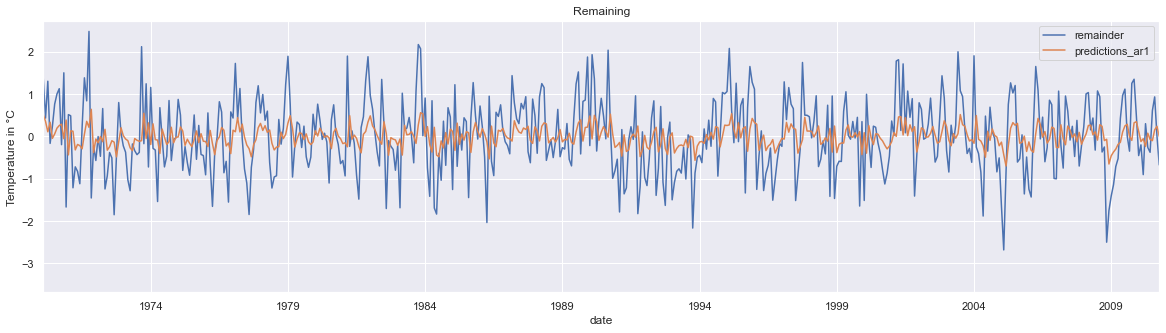

In [199]:
plot_dataframe(df[['remainder', 'predictions_ar1']],title="Remaining",ymin=df['remainder'].min() - 1)

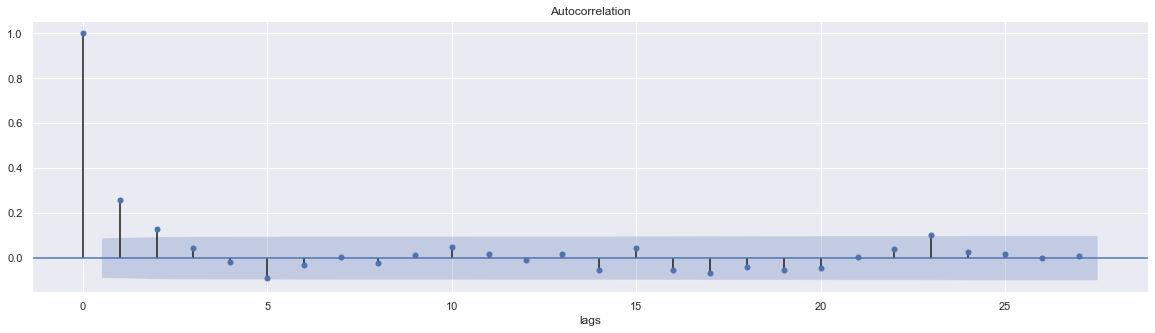

In [200]:
plot_acf(df['remainder'])
plt.xlabel('lags');

In [201]:
df['residual'] = df['remainder'] - df['predictions_ar1']
df.head()

remainder      lag1  predictions_ar1  residual
date                                                      
1970-02-01   1.368739  1.995418         0.513673  0.855065
1970-03-01   0.429879  1.368739         0.350955  0.078924
1970-04-01   1.300936  0.429879         0.107180  1.193757
1970-05-01  -0.166895  1.300936         0.333350 -0.500245
1970-06-01   0.235733 -0.166895        -0.047773  0.283506

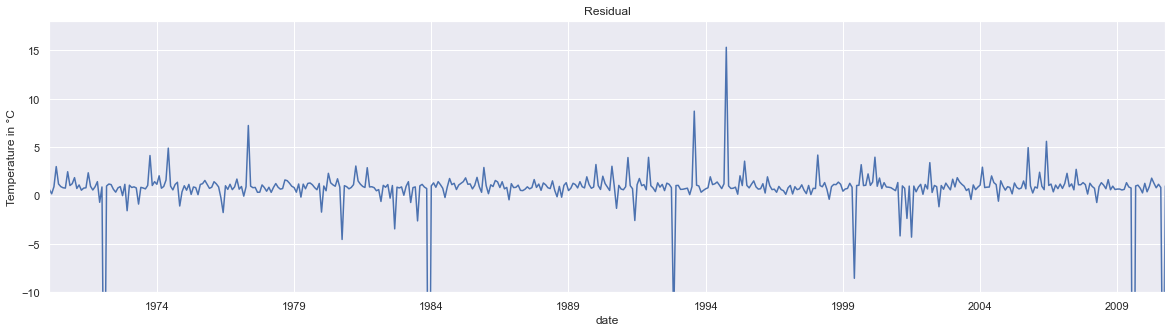

In [202]:
plot_dataframe(df['residual']/df['remainder'],title='Residual')

Add lag2

In [203]:
df['lag2'] = df['remainder'].shift(2)
df.head()

remainder      lag1  predictions_ar1  residual      lag2
date                                                                
1970-02-01   1.368739  1.995418         0.513673  0.855065       NaN
1970-03-01   0.429879  1.368739         0.350955  0.078924       NaN
1970-04-01   1.300936  0.429879         0.107180  1.193757  1.368739
1970-05-01  -0.166895  1.300936         0.333350 -0.500245  0.429879
1970-06-01   0.235733 -0.166895        -0.047773  0.283506  1.300936

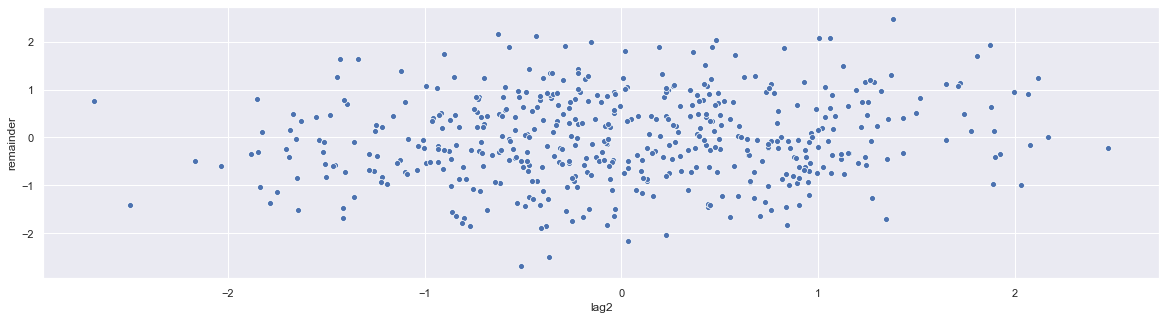

In [204]:
sns.scatterplot(x='lag2', y='remainder', data=df)

In [205]:
round(df[['remainder', 'lag1', 'lag2']].corr(), 2)

remainder  lag1  lag2
remainder       1.00  0.26  0.13
lag1            0.26  1.00  0.26
lag2            0.13  0.26  1.00

### Partial Autocorrelation

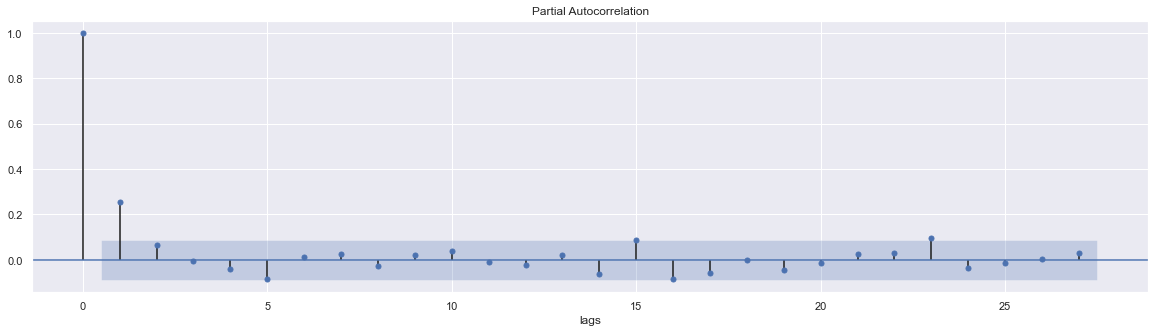

In [206]:
plot_pacf(df['remainder'])
plt.xlabel('lags');

### Statsmodels

In [207]:
selected_order = ar_select_order(df['remainder'], maxlag = 12)

In [208]:
selected_order.ar_lags

array([1])

In [209]:
ar_model = AutoReg(endog=df['remainder'], lags=1).fit()

In [210]:
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                  489
Model:                     AutoReg(1)   Log Likelihood                -618.891
Method:               Conditional MLE   S.D. of innovations              0.860
Date:                Fri, 12 Mar 2021   AIC                             -0.289
Time:                        14:15:53   BIC                             -0.263
Sample:                    03-01-1970   HQIC                            -0.279
                         - 10-01-2010                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.0062      0.039     -0.159      0.873      -0.083       0.070
remainder.L1     0.2552      0.044      5.843      0.000       0.170       0.341
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.9178           +0.0000j            3.9178            0.0000
-----------------------------------------------------------------------------
"""

## Run LR on full Model

In [211]:
spain_train = add_lag(spain_train)
spain_train

YEAR  MONTH       TEMP  timestep      trend  month_2  month_3  \
date                                                                        
1970-02-01  1970      2  13.389286         1  17.234276        1        0   
1970-03-01  1970      3  13.870968         2  17.238413        0        1   
1970-04-01  1970      4  16.380000         3  17.242550        0        0   
1970-05-01  1970      5  17.883871         4  17.246687        0        0   
1970-06-01  1970      6  21.993333         5  17.250825        0        0   
...          ...    ...        ...       ...        ...      ...      ...   
2010-06-01  2010      6  23.143333       485  19.236686        0        0   
2010-07-01  2010      7  26.664516       486  19.240823        0        0   
2010-08-01  2010      8  27.545161       487  19.244960        0        0   
2010-09-01  2010      9  24.183333       488  19.249097        0        0   
2010-10-01  2010     10  19.483871       489  19.253234        0        0   

            month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
date                                                                         
1970-02-01        0        0        0        0        0        0         0   
1970-03-01        0        0        0        0        0        0         0   
1970-04-01        1        0        0        0        0        0         0   
1970-05-01        0        1        0        0        0        0         0   
1970-06-01        0        0        1        0        0        0         0   
...             ...      ...      ...      ...      ...      ...       ...   
2010-06-01        0        0        1        0        0        0         0   
2010-07-01        0        0        0        1        0        0         0   
2010-08-01        0        0        0        0        1        0         0   
2010-09-01        0        0        0        0        0        1         0   
2010-10-01        0        0        0        0        0        0         1   

            month_11  month_12  trend_seasonal  remainder     random      lag1  
date                                                                            
1970-02-01         0         0       12.020547   1.368739  -4.950107  1.995418  
1970-03-01         0         0       13.441088   0.429879   1.362194  1.368739  
1970-04-01         0         0       15.079064   1.300936 -28.583666  0.429879  
1970-05-01         0         0       18.050766  -0.166895  -8.775100  1.300936  
1970-06-01         0         0       21.757600   0.235733  -8.708092 -0.166895  
...              ...       ...             ...        ...        ...       ...  
2010-06-01         0         0       23.519798  -0.376465  24.344841 -0.264576  
2010-07-01         0         0       26.058676   0.605841 -10.281273 -0.376465  
2010-08-01         0         0       26.614537   0.930624  -4.943934  0.605841  
2010-09-01         0         0       24.174107   0.009226  -1.250618  0.930624  
2010-10-01         0         0       20.158518  -0.674647   1.214101  0.009226  

[489 rows x 20 columns]

In [212]:
# Assign X
X_full = spain_train.drop(columns=['YEAR', 'MONTH', 'TEMP', 'trend', 'trend_seasonal','remainder','random'])
y_full = spain_train['TEMP']

In [213]:
X_full.head()

timestep  month_2  month_3  month_4  month_5  month_6  month_7  \
date                                                                         
1970-02-01         1        1        0        0        0        0        0   
1970-03-01         2        0        1        0        0        0        0   
1970-04-01         3        0        0        1        0        0        0   
1970-05-01         4        0        0        0        1        0        0   
1970-06-01         5        0        0        0        0        1        0   

            month_8  month_9  month_10  month_11  month_12      lag1  
date                                                                  
1970-02-01        0        0         0         0         0  1.995418  
1970-03-01        0        0         0         0         0  1.368739  
1970-04-01        0        0         0         0         0  0.429879  
1970-05-01        0        0         0         0         0  1.300936  
1970-06-01        0        0         0         0         0 -0.166895

In [214]:
m_full = LinearRegression()
m_full.fit(X_full, y_full)

LinearRegression()

In [215]:
# Create a new predictions column
spain_train['predictions_full_model'] = m_full.predict(X_full)

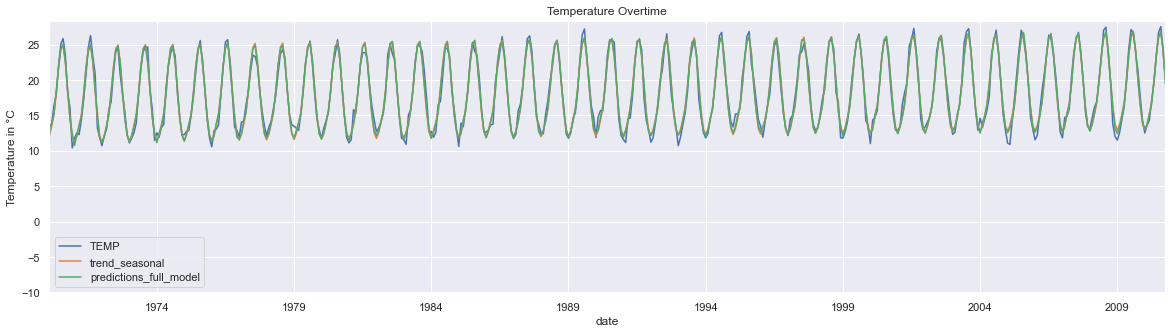

In [216]:
#Plot the prediction vs passengers for the training data

plot_dataframe(spain_train[['TEMP', 'trend_seasonal', 'predictions_full_model']])

In [217]:
pd.DataFrame(m_full.coef_.reshape(1,13), columns=X_full.columns)

timestep   month_2   month_3   month_4   month_5    month_6    month_7  \
0  0.003717  0.868861  2.285685  3.919943  6.887928  10.591045  13.126206   

    month_8    month_9  month_10  month_11  month_12      lag1  
0  13.67835  11.234203  7.214897  3.418184  0.873395  0.259631

## Cross Validate and Optimizing Hyperparameters

In [218]:
X_full

timestep  month_2  month_3  month_4  month_5  month_6  month_7  \
date                                                                         
1970-02-01         1        1        0        0        0        0        0   
1970-03-01         2        0        1        0        0        0        0   
1970-04-01         3        0        0        1        0        0        0   
1970-05-01         4        0        0        0        1        0        0   
1970-06-01         5        0        0        0        0        1        0   
...              ...      ...      ...      ...      ...      ...      ...   
2010-06-01       485        0        0        0        0        1        0   
2010-07-01       486        0        0        0        0        0        1   
2010-08-01       487        0        0        0        0        0        0   
2010-09-01       488        0        0        0        0        0        0   
2010-10-01       489        0        0        0        0        0        0   

            month_8  month_9  month_10  month_11  month_12      lag1  
date                                                                  
1970-02-01        0        0         0         0         0  1.995418  
1970-03-01        0        0         0         0         0  1.368739  
1970-04-01        0        0         0         0         0  0.429879  
1970-05-01        0        0         0         0         0  1.300936  
1970-06-01        0        0         0         0         0 -0.166895  
...             ...      ...       ...       ...       ...       ...  
2010-06-01        0        0         0         0         0 -0.264576  
2010-07-01        0        0         0         0         0 -0.376465  
2010-08-01        1        0         0         0         0  0.605841  
2010-09-01        0        1         0         0         0  0.930624  
2010-10-01        0        0         1         0         0  0.009226  

[489 rows x 13 columns]

In [219]:
# Create a TimeSeriesSplit object
ts_split = TimeSeriesSplit(n_splits=5)

In [220]:
# Split the training data into folds
for i, (train_index, validation_index) in enumerate(ts_split.split(X_full, y_full)):
    print(f"""The training data for the {i+1}th iteration are the observations steps 
    {train_index}""")
    print(f"""The validation data for the {i+1}th iteration are the observations steps
    {validation_index}""")
    print('\n')

The training data for the 1th iteration are the observations steps 
    [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
The validation data for the 1th iteration are the observations steps
    [ 84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164]


The training data for the 2th iteration are the observations steps 
    [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47

In [221]:
# Create the time series split
time_series_split = ts_split.split(X_full, y_full) 

In [222]:
# Do the cross validation
result = cross_val_score(estimator=m_full, X=X_full, y=y_full,
                         cv=time_series_split)
result

array([0.92025455, 0.9675104 , 0.95609646, 0.96772743, 0.97080968])

In [223]:
spain_cv_mean = result.mean()
spain_cv_mean

0.9564797052865064

In [224]:
result_ordinary_cv = cross_val_score(estimator=m_full, X=X_full, y=y_full, cv=5)
result_ordinary_cv

array([0.96356883, 0.96021614, 0.96987098, 0.96548937, 0.97030105])

In [225]:
spain_result_ordinary_cv = result_ordinary_cv.mean()
spain_result_ordinary_cv

0.9658892737115099

## Testing

In [226]:
spain_test.head()

YEAR  MONTH       TEMP  timestep
date                                        
2010-11-01  2010     11  15.406667       490
2010-12-01  2010     12  13.429032       491
2011-01-01  2011      1  12.964516       492
2011-02-01  2011      2  13.164286       493
2011-03-01  2011      3  14.470968       494

In [227]:
# Last timestep of the training data
last_train_timestep = spain_train['timestep'][-1] + 1

In [228]:
# Create a timestep for the model
spain_test['timestep'] = list(range(last_train_timestep + 1, len(spain_test) + last_train_timestep + 1))
spain_test.head()

YEAR  MONTH       TEMP  timestep
date                                        
2010-11-01  2010     11  15.406667       491
2010-12-01  2010     12  13.429032       492
2011-01-01  2011      1  12.964516       493
2011-02-01  2011      2  13.164286       494
2011-03-01  2011      3  14.470968       495

In [229]:
seasonal_dummies = pd.get_dummies(spain_test.index.month, 
                                  prefix='month', 
                                 drop_first=True).set_index(spain_test.index)

spain_test = spain_test.join(seasonal_dummies)
spain_test.head()

YEAR  MONTH       TEMP  timestep  month_2  month_3  month_4  \
date                                                                      
2010-11-01  2010     11  15.406667       491        0        0        0   
2010-12-01  2010     12  13.429032       492        0        0        0   
2011-01-01  2011      1  12.964516       493        0        0        0   
2011-02-01  2011      2  13.164286       494        1        0        0   
2011-03-01  2011      3  14.470968       495        0        1        0   

            month_5  month_6  month_7  month_8  month_9  month_10  month_11  \
date                                                                          
2010-11-01        0        0        0        0        0         0         1   
2010-12-01        0        0        0        0        0         0         0   
2011-01-01        0        0        0        0        0         0         0   
2011-02-01        0        0        0        0        0         0         0   
2011-03-01        0        0        0        0        0         0         0   

            month_12  
date                  
2010-11-01         0  
2010-12-01         1  
2011-01-01         0  
2011-02-01         0  
2011-03-01         0

In [230]:
# Assign X_test
X_test = spain_test.drop(columns=['TEMP'])

In [231]:
# Predict trend and seasonality
spain_m, spain_X, spain_y= model_linear_regression(spain_test)
spain_test = calculate_seasonal_trend(spain_test, spain_m, spain_X)
spain_test.head()

YEAR  MONTH       TEMP  timestep  month_2  month_3  month_4  \
date                                                                      
2010-11-01  2010     11  15.406667       491        0        0        0   
2010-12-01  2010     12  13.429032       492        0        0        0   
2011-01-01  2011      1  12.964516       493        0        0        0   
2011-02-01  2011      2  13.164286       494        1        0        0   
2011-03-01  2011      3  14.470968       495        0        1        0   

            month_5  month_6  month_7  month_8  month_9  month_10  month_11  \
date                                                                          
2010-11-01        0        0        0        0        0         0         1   
2010-12-01        0        0        0        0        0         0         0   
2011-01-01        0        0        0        0        0         0         0   
2011-02-01        0        0        0        0        0         0         0   
2011-03-01        0        0        0        0        0         0         0   

            month_12  trend_seasonal  
date                                  
2010-11-01         0       18.775054  
2010-12-01         1       18.782690  
2011-01-01         0       18.790326  
2011-02-01         0       18.797962  
2011-03-01         0       18.805598

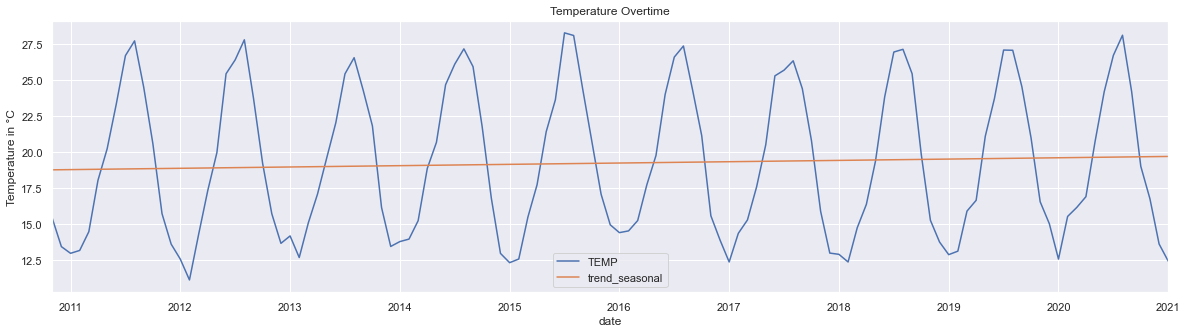

In [232]:
plot_dataframe(spain_test[['TEMP', 'trend_seasonal']], ylim=False)

In [233]:
# Calculate the remainder for the test set
spain_test['remainder'] = spain_test['TEMP'] - spain_test['trend_seasonal']

# Create the lagged variable
spain_test['lag1'] = spain_test['remainder'].shift(1)

In [234]:
# Assign X_full
X_full = spain_test.drop(columns=['YEAR','MONTH','TEMP', 'trend_seasonal', 'remainder'])

In [235]:
X_full.head() # Contains a NaN for the first value of lag1

timestep  month_2  month_3  month_4  month_5  month_6  month_7  \
date                                                                         
2010-11-01       491        0        0        0        0        0        0   
2010-12-01       492        0        0        0        0        0        0   
2011-01-01       493        0        0        0        0        0        0   
2011-02-01       494        1        0        0        0        0        0   
2011-03-01       495        0        1        0        0        0        0   

            month_8  month_9  month_10  month_11  month_12      lag1  
date                                                                  
2010-11-01        0        0         0         1         0       NaN  
2010-12-01        0        0         0         0         1 -3.368387  
2011-01-01        0        0         0         0         0 -5.353658  
2011-02-01        0        0         0         0         0 -5.825810  
2011-03-01        0        0         0         0         0 -5.633676

In [236]:
X_full.loc['2010-11-01', 'lag1'] = spain_train.loc['2010-10-01', 'remainder']

In [237]:
# Create the predictions
spain_test['predictions_full_model'] = m_full.predict(X_full)

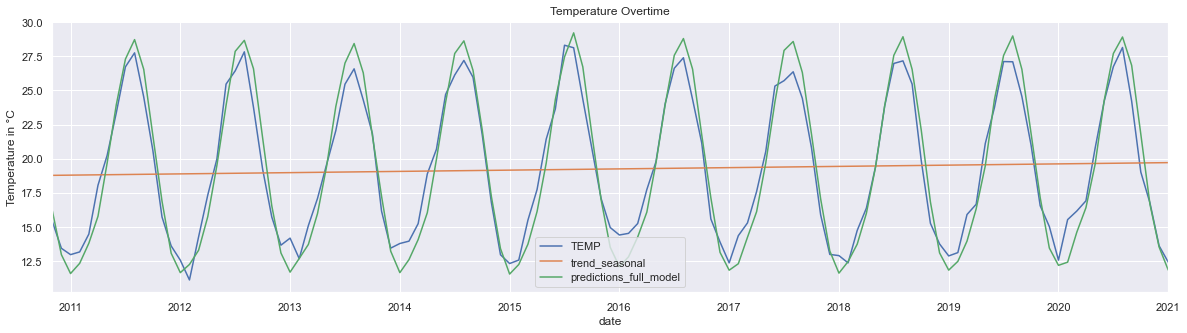

In [238]:
plot_dataframe(spain_test[['TEMP', 'trend_seasonal', 'predictions_full_model']], ylim=False)

In [239]:
# Create the complete dataset and plot it
spain_full = spain_train[['TEMP', 'trend_seasonal', 'predictions_full_model']].append(spain_test[['TEMP', 'trend_seasonal', 'predictions_full_model']])

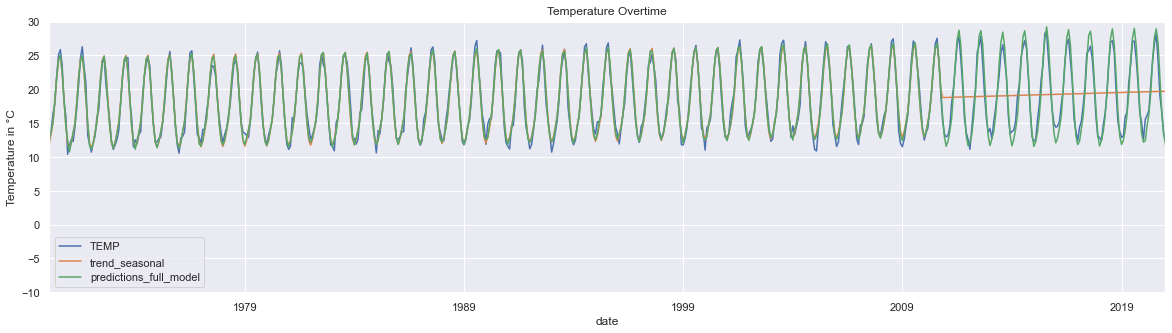

In [240]:
plot_dataframe(spain_full)

In [241]:
spain_test_lr_score = m_full.score(X_full, spain_test['TEMP'])
spain_test_lr_score

0.9307763557003402

## Predict the future


In [242]:
spain_test.head()

YEAR  MONTH       TEMP  timestep  month_2  month_3  month_4  \
date                                                                      
2010-11-01  2010     11  15.406667       491        0        0        0   
2010-12-01  2010     12  13.429032       492        0        0        0   
2011-01-01  2011      1  12.964516       493        0        0        0   
2011-02-01  2011      2  13.164286       494        1        0        0   
2011-03-01  2011      3  14.470968       495        0        1        0   

            month_5  month_6  month_7  month_8  month_9  month_10  month_11  \
date                                                                          
2010-11-01        0        0        0        0        0         0         1   
2010-12-01        0        0        0        0        0         0         0   
2011-01-01        0        0        0        0        0         0         0   
2011-02-01        0        0        0        0        0         0         0   
2011-03-01        0        0        0        0        0         0         0   

            month_12  trend_seasonal  remainder      lag1  \
date                                                        
2010-11-01         0       18.775054  -3.368387       NaN   
2010-12-01         1       18.782690  -5.353658 -3.368387   
2011-01-01         0       18.790326  -5.825810 -5.353658   
2011-02-01         0       18.797962  -5.633676 -5.825810   
2011-03-01         0       18.805598  -4.334630 -5.633676   

            predictions_full_model  
date                                
2010-11-01               16.205113  
2010-12-01               12.964661  
2011-01-01               11.579545  
2011-02-01               12.329538  
2011-03-01               13.799963

In [243]:
spain_combined = spain_train.append(spain_test)
spain_combined.tail()

YEAR  MONTH       TEMP  timestep  trend  month_2  month_3  \
date                                                                    
2020-09-01  2020      9  24.213333       609    NaN        0        0   
2020-10-01  2020     10  19.016129       610    NaN        0        0   
2020-11-01  2020     11  16.756667       611    NaN        0        0   
2020-12-01  2020     12  13.612903       612    NaN        0        0   
2021-01-01  2021      1  12.416129       613    NaN        0        0   

            month_4  month_5  month_6  ...  month_8  month_9  month_10  \
date                                   ...                               
2020-09-01        0        0        0  ...        0        1         0   
2020-10-01        0        0        0  ...        0        0         1   
2020-11-01        0        0        0  ...        0        0         0   
2020-12-01        0        0        0  ...        0        0         0   
2021-01-01        0        0        0  ...        0        0         0   

            month_11  month_12  trend_seasonal  remainder  random      lag1  \
date                                                                          
2020-09-01         0         0       19.676107   4.537226     NaN  8.476690   
2020-10-01         0         0       19.683743  -0.667614     NaN  4.537226   
2020-11-01         1         0       19.691379  -2.934713     NaN -0.667614   
2020-12-01         0         1       19.699015  -6.086112     NaN -2.934713   
2021-01-01         0         0       19.706651  -7.290522     NaN -6.086112   

            predictions_full_model  
date                                
2020-09-01               26.835735  
2020-10-01               21.797338  
2020-11-01               16.653004  
2020-12-01               13.523322  
2021-01-01               11.835443  

[5 rows x 21 columns]

In [244]:
# Re-train the model on the whole dataset
X_combined = spain_combined.drop(columns=['YEAR','MONTH','TEMP', 'trend_seasonal', 'remainder', 'predictions_full_model','trend','random'])
y_combined = spain_combined['TEMP']

In [245]:
X_combined.loc['2010-11-01', 'lag1'] = spain_train.loc['2010-10-01', 'remainder']


In [246]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [247]:
X_combined.head(1)

timestep  month_2  month_3  month_4  month_5  month_6  month_7  \
date                                                                         
1970-02-01         1        1        0        0        0        0        0   

            month_8  month_9  month_10  month_11  month_12      lag1  
date                                                                  
1970-02-01        0        0         0         0         0  1.995418

In [248]:
[0] * 11

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [249]:
# What is the first date in the future? --> 2021-02-01
timestep = spain_combined['timestep'].max() + 1
months = [0] * 11
lag = spain_combined.loc['2021-01-01', 'remainder']

In [250]:
timestep, months, lag

(614, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], -7.290522418107159)

In [251]:
X_future = []

X_future.append(timestep)

X_future.extend(months)

X_future.append(lag)

X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

X_future

timestep  month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
0       614        0        0        0        0        0        0        0   

   month_9  month_10  month_11  month_12      lag1  
0        0         0         0         0 -7.290522

In [252]:
# Prediction for 2021-02-01

spain_f1 = m_combined.predict(X_future)
spain_f1 = spain_f1.round(4)

In [253]:
# How does this look like for 2021-03-01?
timestep = spain_combined['timestep'].max() + 1
months = [1] + [0]*10
lag = 0 


In [254]:
X_future_2 = pd.DataFrame([[timestep] + months + [lag]])
X_future_2.columns = X_combined.columns
X_future_2

timestep  month_2  month_3  month_4  month_5  month_6  month_7  month_8  \
0       614        1        0        0        0        0        0        0   

   month_9  month_10  month_11  month_12  lag1  
0        0         0         0         0     0

In [255]:
# Prediction for 2021-03-01

spain_f2 = m_combined.predict(X_future_2)
spain_f2 = spain_f2.round(4)

# Summary

In [256]:
def highlight_column(s, col):
    return ['background-color: #00FA9A' if s.name == col else '' for v in s.index]

In [260]:
all_summary = pd.DataFrame({
    "Country":['Germany (Hamburg)', 'Norway(Tromso)', 'Spain (Malaga)'],
    "CV Score": [germany_cv_mean, norway_cv_mean, spain_cv_mean],
    "CV Ordinary Score": [germany_result_ordinary_cv, norway_result_ordinary_cv, spain_result_ordinary_cv],
    "Linear Regression Score": [germany_test_lr_score, norway_test_lr_score, spain_test_lr_score],
    "Forecast Feb 2021 in °C":[germany_f1, norway_f1, spain_f1],
    "Actual Feb 2021 in°C*": ["1.0", "-5.7", "11.2"],
    "Forecast Mar 2021 in °C":[germany_f2, norway_f2, spain_f2]
    
})
all_summary.round(4)
all_summary.style.apply(highlight_column, col = 'Actual Feb 2021 in°C*')


*actual data from weather2visit.com